# Run Spectral Predictions for Trained UVvis-SchNet Models

This notebook outlines the code required to make a UV-vis spectral prediction from a trained UVvis-SchNet model. This model loads in the following from the model directory:

- The desired compounds' xyz file with 3D coordinates
- The path to the file containing the trained model (best_model)
- The path to the atomic reference file (atomref.npy)

The code will then run the predictions based on these inputs and output a result file that you can plot to display the predicted spectra.

In [2]:
# Load packages necessary for running the prediction

from jcesr_ml.schnetpack import load_model, run_model
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.style import model_style
from ase.units import Hartree, eV
from io import StringIO
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
from schnetpack.atomistic import AtomisticModel
from schnetpack.md import AtomsConverter
from schnetpack.data import AtomsData
from ase.io.extxyz import read_xyz
from io import StringIO
from tqdm import tqdm
import numpy as np
import shutil
import torch
import json
import os
import schnetpack

## Read in the Data
We saved it to a JSON file in a previous notebook. Get only the molecules larger than our training set

In [3]:
#data = pd.read_json('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/ESol_delta/xyz_files/CNOFH_final_validation_seperated/ESol_100_predict.json')
#data = pd.read_json('/qfs/projects/MulCME/Rajendra/darpa/MMPI_set3/989_compounds_UV/Experimental_data/scripts/to_predict_new/one_for_each/580.json', lines = True)
#data = pd.read_json('/qfs/projects/MulCME/Rajendra/darpa/MMPI_set3/Regioisomers/not_in_9888_molecules_dft_expt_files/regioisomers_not_training/json_files/4781.json', lines = True)
#data = pd.read_json('/qfs/projects/MulCME/Rajendra/darpa/MMPI_set3/989_compounds_UV/Experimental_data/scripts/to_predict_new/worst_case.json', lines = True)
#data = pd.read_json('/qfs/projects/MulCME/Rajendra/darpa/MMPI_set3/989_compounds_UV/Experimental_data/schnet_delta_v2/CNOFH/final_training_set/val/total.json', lines=True)
data = pd.read_json('/qfs/projects/MulCME/Rajendra/darpa/MMPI_set3/TRAIN_TEST_VALIDATION/VALIDATION_DATA/SchNet_Data_w_Spectra/JSON/93_Validation_SchNet.json', lines=True)
print('Read data of {} molecules'.format(len(data)))

Read data of 90 molecules


In [37]:
for number in data['g4mp2_0k']:
    print(number)

1.0 0.9920113166519233 0.9749817819050477 0.9475085050250767 0.9085393179612881 0.8558529770510458 0.789410513107286 0.7113552314185174 0.6261685884970754 0.538098225732913 0.45361302817861915 0.3778179593395502 0.3125445710077042 0.25779286318308114 0.21422531204576542 0.17942582799780213 0.15249811973672417 0.13141578953521452 0.11489285422016811 0.10148745387022481 0.09077092742768293 0.08231461383484079 0.07533912935042263 0.0695716896649819 0.06501229477851862 0.061466098755713856 0.05889413240950381 0.05694567305631437 0.05573762825733693 0.05516478120749923 0.055223234988094914 0.05581946355017088 0.05698853916208454 0.05849274978274678 0.06063995198996154 0.06305214466921005 0.06594365834934317 0.06911575017633557 0.07249048177605967 0.07607564698592822 0.07989073039947314 0.08397470120375819 0.08820675491888563 0.09245829322754498 0.09670203769879157 0.1011406281053571 0.10563377537381193 0.1098814167637649 0.11399656291770098 0.11822471971412205 0.12198134934707128 0.12564055

## RUN MODEL

In [9]:
for number in data['u0']:
    print(number)

0.8509952103236045 0.8643865589293509 0.8826064948609246 0.9045827134734183 0.9287078956672847 0.9528501079122027 0.9744829027888986 0.9909716985875265 0.9999953503101235 1.0 0.990526395470394 0.9722761020329844 0.9468891498215948 0.9165294098811445 0.8834345388897717 0.8495612003348986 0.8163835475167407 0.7848373642573022 0.7553698891993728 0.7280516835953946 0.7027147984919421 0.6790895029038726 0.6569165852377035 0.6360178262435999 0.6163170712030229 0.5978173252724539 0.5805502875745876 0.5645188209092009 0.54964984874799 0.5357684286923685 0.5225970907480626 0.5097795678881238 0.4969242473437227 0.4836591146638261 0.4696868546981166 0.45482766858409357 0.43903987156187946 0.4224144882349432 0.4051475888050549 0.3874997584131178 0.36975371959703157 0.3521788760193264 0.33500730042174925 0.31842161527383483 0.3025525597493739 0.28748304139906977 0.2732556206755884 0.2598811167357062 0.24734688290690507 0.23562398079804056 0.22467298563484642 0.21444844496236384 0.2049021514122565 0

In [4]:
def run_modelX(model, data, xyz_col, additional_cols=None, progbar=True):
    """Runs a SchNetPack model on the column of a dataframe containing XYZ files
    Args:
        model (AtomisticModel): Model to be evaluated
        data (DataFrame): Data to be evaluated
        xyz_col (string): Column containing the XYZ data
        additional_cols ([string]): Any other columns to add to the input (e.g., B3LYP results)
        progbar (boolean): Whether to display a progress bar
    Returns:
        (ndarray) Predictions from the model
    """

    # Get default value for additional_cols
    if additional_cols is None:
        additional_cols = []

    # Make the tool to convert ase.Atoms to SchNet inputs
    c = AtomsConverter()
    
    results = []
    for xyz, more_data in tqdm(list(zip(data[xyz_col], data[additional_cols].values)),
                               disable=not progbar, leave=False):
        # Convert the XYZ file to an ASE object
        atoms = next(read_xyz(StringIO(xyz),0)) 
        # Generate it in the input format needed
        inputs = c.convert_atoms(atoms)
        print(inputs)
        #inputs = atoms
        # Add in the additional columns
        for i, col in enumerate(additional_cols):
            #u0 = [float(i) for i in more_data[i].split()]
            u0 = [float(i)]
            inputs[col] = torch.Tensor(np.expand_dims(u0, 0))

        # Run it through the model
        print(inputs)
        outputs = model(inputs)

        # Get the value in numpy format
        results.append(np.squeeze(outputs['y'].cpu().data.numpy()))

    return np.array(results)

### Evaluate Models

In [6]:
#net_dir = '/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_2/diff_weight/5/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/direct/larger_validation/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_1/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/direct/larger_validation/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_2/diff_weight/5/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_1/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-SchNet/weighted_models_final/direct/larger_validation/model/good_model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-SchNet/several_models_tested/direct/model/best_model'
#net_dir = '/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-SchNet/weighted_models_final/rdkit_run/model_best_run_uncertain_validation/best_model'
net_dir = '/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-Bench/UVvis-SchNet/UnOpt_Coords_Model/model/best_model'

In [7]:
model = torch.load(net_dir)

In [8]:
#atomref = np.load('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_2/diff_weight/5/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/direct/larger_validation/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_1/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/direct/larger_validation/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_2/diff_weight/5/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/schnet_delta_UV/schnet-delta/networks/new_data_run/direct/validation_set_seperated_March26/weighted_models/weighted_1/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-SchNet/weighted_models_final/direct//larger_validation/model/good_model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-SchNet/several_models_tested/direct/model/atomref.npy')
#atomref = np.load('/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-SchNet/weighted_models_final/rdkit_run/model_best_run_uncertain_validation/atomref.npy')
atomref = np.load('/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-Bench/UVvis-SchNet/UnOpt_Coords_Model/model/atomref.npy')

In [9]:
# Loading the model
from schnetpack.atomistic import Atomwise, AtomisticModel, DeltaLearning
from schnetpack.representation import SchNet
#model = torch.load(os.path.join(net_dir, 'architecture.pth'))
reps = SchNet(n_atom_basis=256, n_filters=256, n_interactions=6,
          cutoff=5, n_gaussians=25, max_z=35)
output = Atomwise(256, n_out=181, atomref=atomref,
             mean=torch.Tensor([0]*(181)),
             stddev=torch.Tensor([1]*(181)),
             train_embeddings=True)
model = AtomisticModel(reps, output)
model.load_state_dict(torch.load(net_dir))

<All keys matched successfully>

In [10]:
data = run_modelX( model, data, 'xyz', ['u0'])

  0%|          | 0/90 [00:00<?, ?it/s]/people/mcna892/.conda/envs/g4mp2_ml/lib/python3.7/site-packages/ase/atoms.py:968: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


{'_atomic_numbers': tensor([[6, 6, 7, 6, 8, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6,
         8, 8, 6, 6, 6, 6, 6, 6, 6, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-4.7972e+00, -1.0008e-01, -1.6344e+00],
         [-4.9296e+00,  4.7334e-01, -2.1809e-01],
         [-3.6756e+00,  1.0116e+00,  2.6969e-01],
         [-3.7250e+00,  1.7049e+00,  1.4641e+00],
         [-4.7988e+00,  2.0695e+00,  1.9264e+00],
         [-2.4154e+00,  1.9534e+00,  2.2077e+00],
         [-1.1673e+00,  2.2185e+00,  1.3160e+00],
         [-1.0717e-04,  1.2775e+00,  1.6381e+00],


  1%|          | 1/90 [00:01<01:30,  1.02s/it]

{'_atomic_numbers': tensor([[ 6, 16,  6,  6,  6,  7,  6,  8,  6,  8,  6,  6,  6,  6,  6,  6,  8,  6,
          8,  6,  6,  6,  6,  6,  6,  6,  8,  7,  6,  6,  6,  8,  8,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.7943, -0.5373,  0.2772],
         [ 4.3619,  1.0906, -0.4341],
         [ 2.9914,  1.5629,  0.7006],
         [ 1.6712,  0.8486,  0.4000],
         [ 1.0590,  1.2704, -0.9746],
         [-0.1818,  2.0063, -0.8305],
         [-0.2807,  3.1752, -0.1574],
         [ 0.6734,  3.8531,  0.2129],
         [-1.7319,  3.5996,  0.1237],
         [-2.5640,  2.4751,  0.4352],
      

  2%|▏         | 2/90 [00:02<01:31,  1.04s/it]

{'_atomic_numbers': tensor([[6, 8, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6,
         6, 6, 6, 8, 8, 6, 8, 8, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]), '_positions': tensor([[[ 6.9798e+00,  3.1947e+00, -2.4959e+00],
         [ 6.1629e+00,  3.4315e+00, -1.3582e+00],
         [ 5.3401e+00,  2.4408e+00, -9.2398e-01],
         [ 5.2611e+00,  1.1725e+00, -1.5202e+00],
         [ 4.3862e+00,  2.1196e-01, -1.0091e+00],
         [ 4.2873e+00, -1.0252e+00, -1.5675e+00],
         [ 5.0492e+00, -1.3397e+00, -2.7231e+00],
         [ 3.5554e+00,  4.7890e-01,  1.1843e-01],
         [ 2.5994e+00, -4.3721e-01,  7.3530e-01],
         [ 2.4143e+00, -1.8

  3%|▎         | 3/90 [00:03<01:29,  1.03s/it]

{'_atomic_numbers': tensor([[ 6, 16,  8,  8,  7,  6,  6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  7,
          6,  8,  6,  6,  6,  6,  6,  6,  6,  8,  6,  6,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-7.2290,  0.9246, -0.6663],
         [-5.8992, -0.2569, -0.3740],
         [-5.2686, -0.5533, -1.6603],
         [-6.4305, -1.3257,  0.4764],
         [-4.8312,  0.7062,  0.5380],
         [-5.1018,  0.7746,  2.0038],
         [-3.8763,  1.5270,  2.5557],
         [-2.8139,  1.2180,  1.5281],
         [-1.4396,  1.3942,  1.5894],
         [-0.6542,  1.1001,  0.4703],
         [-1.2668,  0.6182, -0.6895],
         [-0.4311,  0.3117, -1.8185],
         [ 0.1729, -1.2909, -1.9578],
      

  4%|▍         | 4/90 [00:04<01:29,  1.04s/it]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 6, 6, 8, 8, 6, 6, 6, 8, 6, 6, 8, 7, 6, 6, 6, 6, 7, 6, 6, 6,
         6, 6, 6, 6, 8, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]]), '_positions': tensor([[[-7.0647,  0.8166, -3.0108],
         [-6.5581,  0.8665, -1.5671],
         [-6.2925, -0.5423, -0.9940],
         [-5.7706, -0.5009,  0.4213],
         [-6.5987, -0.7352,  1.4722],
         [-6.1744, -0.6469,  2.8599],
         [-6.8661, -0.8328,  3.8337],
         [-4.8346, -0.3083,  3.0714],
         [-3.9721, -0.0782,  2.0411],
         [-2.6655,  0.2415,  2.3912],
         [-1.7269,  0.4875,  1.3891],
         [-0.4780,  0.8146,  1.8307],
         [ 0.5299,  1.0810, 

  6%|▌         | 5/90 [00:05<01:26,  1.02s/it]

{'_atomic_numbers': tensor([[ 8,  6,  6,  6,  6,  6,  6,  6,  6,  8,  7,  6,  6, 16,  8,  8,  7,  6,
          6,  6,  6,  6,  6,  7,  6,  8,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 3.3580, -1.1930,  2.9806],
         [ 3.6724, -0.5514,  1.9991],
         [ 4.9643, -0.5032,  1.2606],
         [ 6.1627, -1.1535,  1.5076],
         [ 7.2162, -0.9217,  0.6121],
         [ 7.0576, -0.0678, -0.4872],
         [ 5.8400,  0.5837, -0.7281],
         [ 4.8068,  0.3483,  0.1646],
         [ 3.4127,  0.8646,  0.1709],
         [ 2.8657,  1.6017, -0.6349],
         [ 2.8136,  0.3324,  1.3172],
         [ 1.4004,  0.4478,  1.6282],
         [ 0.5902, -

  7%|▋         | 6/90 [00:06<01:26,  1.03s/it]

{'_atomic_numbers': tensor([[ 6,  6,  7,  7,  6,  6,  6,  6,  6, 17,  6,  6,  6,  6,  6,  8,  7,  6,
          6,  6,  6,  7,  6,  6,  6,  6,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-6.4057e-01,  4.7116e+00, -1.0110e+00],
         [-1.6768e+00,  3.6355e+00, -9.3956e-01],
         [-2.5975e+00,  3.4044e+00, -1.9142e+00],
         [-3.4135e+00,  2.3576e+00, -1.6629e+00],
         [-3.0030e+00,  1.9039e+00, -4.7350e-01],
         [-3.6018e+00,  6.9744e-01,  1.2917e-01],
         [-3.7543e+00, -4.7191e-01, -6.3087e-01],
         [-4.2774e+00, -1.6321e+00, -6.3837e-02],
         [-4.6493e+00, -1.6241e+00,  1.2798e+00],
         [-5.2954e+00, -3.

  8%|▊         | 7/90 [00:07<01:23,  1.01s/it]

{'_atomic_numbers': tensor([[ 6,  6,  7,  6, 16,  6,  6,  8,  7,  6,  6,  6,  6,  7,  6,  6,  6,  6,
          6,  6,  6,  8,  8,  6,  6,  6,  6,  9,  6,  6,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 1.9283, -2.9015, -0.2044],
         [ 2.2351, -1.4299, -0.2646],
         [ 3.5385, -1.0561, -0.4565],
         [ 3.6792,  0.2507, -0.5086],
         [ 2.1775,  1.1383, -0.3354],
         [ 1.3379, -0.3813, -0.1612],
         [-0.1267, -0.3172,  0.0238],
         [-0.7414,  0.7455, -0.1192],
         [-0.7649, -1.4820,  0.3431],
         [-2.1778, -1.4692,  0.6592],
         [-3.0610, -1.3843, -0.6232],
         [-4.4633, -0.9308, -0.3420],
         [-5.6324, -1.6529, -0.4534],
         [-6.7

  9%|▉         | 8/90 [00:08<01:23,  1.02s/it]

{'_atomic_numbers': tensor([[6, 8, 6, 6, 6, 6, 7, 6, 8, 7, 6, 6, 6, 8, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 8, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]]), '_positions': tensor([[[-9.4759e+00,  1.3151e+00, -3.7340e-01],
         [-8.5632e+00,  1.1204e+00,  6.9562e-01],
         [-7.2842e+00,  7.5308e-01,  3.9216e-01],
         [-6.7942e+00,  5.5832e-01, -9.0416e-01],
         [-5.4624e+00,  1.8715e-01, -1.0980e+00],
         [-4.6193e+00, -7.8509e-03, -3.6007e-03],
         [-3.2590e+00, -3.9634e-01, -1.9643e-01],
         [-2.8257e+00, -1.3264e+00, -1.1995e+00],
         [-3.5317e+00, -1.8297e+00, -2.0468e+00],
         [-1.4840e+00, -1.5218e+00

 10%|█         | 9/90 [00:09<01:21,  1.01s/it]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  8,  7,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]]), '_positions': tensor([[[ 4.0282, -3.9516,  0.8227],
         [ 2.8785, -3.9355, -0.0149],
         [ 2.4981, -2.7558, -0.5719],
         [ 1.3399, -2.8112, -1.3648],
         [ 0.8470, -1.6593, -1.9584],
         [ 1.5184, -0.4446, -1.7749],
         [ 0.7872,  1.0657, -2.3901],
         [ 1.8655,  1.9946, -2.7364],
         [-0.2489,  0.6763, -3.3539],
         [-0.0263,  1.7670, -1.0845],
         [ 0.7979,  2.5344, -0.1329],
         [-0.039

 11%|█         | 10/90 [00:10<01:22,  1.03s/it]

{'_atomic_numbers': tensor([[ 8,  6,  6,  6,  6,  6,  6,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  8,
          7,  6,  7,  7,  6,  6,  6,  6,  6,  6, 16,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-0.4229,  2.4937, -1.6877],
         [-1.0470,  1.4706, -1.4640],
         [-0.4633,  0.0762, -1.5394],
         [ 1.0451,  0.0810, -1.8177],
         [ 1.9176,  0.6316, -0.6778],
         [ 1.8173, -0.1723,  0.6238],
         [ 2.7478,  0.3437,  1.7284],
         [ 4.1677,  0.2479,  1.3617],
         [ 4.7420,  1.4320,  0.9860],
         [ 5.9547,  1.4703,  0.6161],
         [ 6.7148,  0.3019,  0.5867],
         [ 8.0543,  0.3970,  0.1659],
         [ 8

 12%|█▏        | 11/90 [00:11<01:20,  1.02s/it]

{'_atomic_numbers': tensor([[ 6, 16,  6,  6,  6,  7,  6,  8,  6,  7,  7,  6,  6,  6,  6,  8,  6,  6,
          6,  6, 16,  6,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-3.6511,  3.7812,  0.1005],
         [-2.2875,  3.0007, -0.8366],
         [-3.2460,  2.0532, -2.0902],
         [-4.1780,  0.9631, -1.5450],
         [-3.5008,  0.0419, -0.5087],
         [-2.1822, -0.4002, -0.9179],
         [-2.0030, -1.1735, -2.0207],
         [-2.9241, -1.6524, -2.6667],
         [-0.5425, -1.4541, -2.4071],
         [ 0.3977, -0.4424, -1.9284],
         [ 1.1114, -0.7748, -0.8361],
         [ 1.9180,  0.1219, -0.3099],
         [ 2.0347,  1.4363, -0.8844],
         [ 1.3

 13%|█▎        | 12/90 [00:12<01:18,  1.00s/it]

{'_atomic_numbers': tensor([[6, 6, 6, 8, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 8, 8, 7, 7, 7, 6, 6,
         6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.1132,  2.7629, -1.7273],
         [ 1.1417,  2.3010, -0.6365],
         [-0.3066,  2.2257, -1.1673],
         [-1.0936,  3.1363, -0.9387],
         [-0.6099,  1.1270, -1.9036],
         [-1.9750,  0.8053, -2.2647],
         [-2.9501,  0.7934, -1.0411],
         [-2.3117,  0.1697,  0.1596],
         [-1.8527,  0.8427,  1.2643],
         [-1.2342, -0.0366,  2.1334],
         [-1.2335, -1.2994,  1.5741],
         [-0.6843, -2.4985,  2.0357],
         [-0.8199, -3.6217,  1.2261],
         [-1.4996, -3.5567, -0.0077],
         [-2.0517

 14%|█▍        | 13/90 [00:13<01:18,  1.02s/it]

{'_atomic_numbers': tensor([[8, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6,
         6, 6, 6, 8, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.9466, -1.0432,  1.8551],
         [ 2.3624, -0.2005,  1.1767],
         [ 3.0072,  0.5407,  0.2127],
         [ 4.3477,  0.4394, -0.1429],
         [ 4.8882,  1.1724, -1.0863],
         [ 6.2155,  0.7569, -1.1106],
         [ 7.2750,  1.1860, -1.9172],
         [ 8.5223,  0.5942, -1.7306],
         [ 8.7233, -0.4080, -0.7620],
         [ 7.6816, -0.8511,  0.0527],
         [ 6.4376, -0.2540, -0.1403],
         [ 5.2045, -0.4355,  0.4692],
         [ 0.8661,  0.0522,  1.2944],
         [ 0.1066, -1.0589,  0.534

 16%|█▌        | 14/90 [00:14<01:16,  1.00s/it]

{'_atomic_numbers': tensor([[8, 6, 6, 6, 7, 6, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 6, 6, 7, 6,
         6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 0.9179,  1.8646, -2.6671],
         [ 0.4678,  2.0317, -1.5377],
         [-0.9501,  2.5760, -1.3525],
         [-1.9477,  1.6087, -2.0106],
         [-3.3113,  2.1092, -2.0862],
         [-4.2302,  1.2371, -1.5576],
         [-5.4418,  1.3263, -1.5457],
         [-3.4835,  0.1756, -0.9938],
         [-4.0816, -0.8272, -0.1117],
         [-4.1204, -0.3476,  1.3242],
         [-3.0529, -0.6184,  2.1890],
         [-3.0666, -0.1295,  3.4963],
         [-4.1444,  0.6377,  3.9457],
         [-5.2072,  0.9174,  3.0831],
   

 17%|█▋        | 15/90 [00:15<01:14,  1.01it/s]

{'_atomic_numbers': tensor([[6, 8, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6,
         7, 6, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-3.8959, -1.9484,  2.0881],
         [-2.9421, -0.9315,  1.7152],
         [-2.0105, -1.2952,  0.8312],
         [-1.8682, -2.4215,  0.3904],
         [-1.1561, -0.1157,  0.3968],
         [-1.7637,  0.5741, -0.8648],
         [-3.1412,  1.1237, -0.6660],
         [-3.4698,  2.3952, -0.2672],
         [-4.8418,  2.5103, -0.1419],
         [-5.4314,  1.3050, -0.4648],
         [-6.7774,  0.9259, -0.4850],
         [-7.0700, -0.3835, -0.8515],
         [-6.0470, -1.2929, -1.1941],
         [-4.7102, -0.9107, -1.1737],
         [-4.3837,  0.4048, -0.8018],
  

 18%|█▊        | 16/90 [00:16<01:12,  1.02it/s]

{'_atomic_numbers': tensor([[ 6, 16,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  7,  6,  6,  8,  7,
          6,  6,  6,  6,  6,  6,  8,  8,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 8.2430, -2.3646, -0.8227],
         [ 6.8745, -3.1480,  0.0933],
         [ 5.5016, -2.0530, -0.1996],
         [ 4.2826, -2.3899,  0.4179],
         [ 3.1592, -1.5953,  0.2487],
         [ 3.2083, -0.4326, -0.5420],
         [ 4.4235, -0.1041, -1.1556],
         [ 5.5577, -0.8993, -0.9913],
         [ 1.9999,  0.4034, -0.7121],
         [ 2.0706,  1.8126, -0.9811],
         [ 0.9281,  2.5373, -1.0982],
         [-0.3646,  1.9071, -0.9295],
         [-1.4599,  2.4749, -0.9681]

 19%|█▉        | 17/90 [00:17<01:14,  1.03s/it]

{'_atomic_numbers': tensor([[ 6, 16,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  7,  6,  6,  8,  7,
          6,  6,  6,  6,  6,  6,  8,  8,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 8.5051e+00,  1.5855e+00, -5.1504e-01],
         [ 7.1200e+00,  2.5686e+00,  1.4880e-01],
         [ 5.7301e+00,  1.4626e+00,  2.0101e-02],
         [ 4.4789e+00,  1.9731e+00,  4.1247e-01],
         [ 3.3399e+00,  1.1856e+00,  3.4572e-01],
         [ 3.4016e+00, -1.4186e-01, -1.1650e-01],
         [ 4.6510e+00, -6.4433e-01, -5.0159e-01],
         [ 5.8023e+00,  1.4096e-01, -4.3608e-01],
         [ 2.1748e+00, -9.6686e-01, -1.8439e-01],
         [ 2.0317e+00, -2.0559e+00, -1.1122e+00],
        

 20%|██        | 18/90 [00:18<01:13,  1.02s/it]

{'_atomic_numbers': tensor([[6, 7, 7, 7, 6, 6, 6, 6, 6, 8, 6, 6, 8, 7, 6, 6, 6, 6, 8, 8, 6, 6, 6, 6,
         6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 8.0469, -1.3112, -2.4264],
         [ 7.2568, -1.1152, -1.2255],
         [ 7.7047, -1.4212, -0.0096],
         [ 6.7379, -1.1171,  0.8186],
         [ 5.7138, -0.6266,  0.0623],
         [ 4.4383, -0.1689,  0.6135],
         [ 3.4275,  0.3203, -0.2222],
         [ 2.2125,  0.7585,  0.3005],
         [ 1.9981,  0.7102,  1.6832],
         [ 0.8607,  1.1368,  2.3152],
         [-0.1780,  1.6879,  1.5438],
         [-0.9280,  0.6274,  0.7120],
         [-0.8294, -0.5684,  0.9412],
         [-1.7235,  1.1534,

 21%|██        | 19/90 [00:19<01:18,  1.11s/it]

{'_atomic_numbers': tensor([[ 8,  6,  6,  6,  6,  6,  6,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  8,
          7,  6,  7,  7,  6, 16,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 0.6266, -1.8274, -2.8268],
         [ 0.8041, -0.6463, -2.5744],
         [ 0.2922,  0.4443, -3.5062],
         [-1.1489,  0.1357, -3.9725],
         [-2.2476,  0.5910, -2.9886],
         [-2.1192,  0.1098, -1.5346],
         [-2.2371, -1.4089, -1.3535],
         [-1.9836, -1.7825,  0.0457],
         [-0.6599, -1.9083,  0.3565],
         [-0.2904, -2.1728,  1.5411],
         [-1.2417, -2.3326,  2.5477],
         [-0.7873, -2.6270,  3.8470],
         [-1.7085, -2.7904,  4.8696],
         [-3.0894, -2.

 22%|██▏       | 20/90 [00:20<01:14,  1.06s/it]

{'_atomic_numbers': tensor([[ 6,  6,  7,  6, 16,  6,  6,  6,  6,  7,  7,  6,  6,  8,  6,  6,  6,  6,
          8,  6,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-5.8708,  2.6112, -0.2919],
         [-5.4433,  1.1940, -0.5451],
         [-4.1316,  0.8641, -0.2558],
         [-3.8709, -0.4023, -0.5152],
         [-5.2510, -1.2943, -1.1470],
         [-6.2117,  0.1731, -1.0370],
         [-7.6516,  0.1656, -1.4549],
         [-2.5906, -1.0135, -0.3027],
         [-1.4713, -0.3387,  0.2111],
         [-1.4369,  0.9698,  0.5141],
         [-0.3982, -1.1764,  0.3715],
         [-0.7673, -2.5308, -0.0557],
         [-2.2377, -2.3895, -0.5071],
         [-2.9192, -3.3195, -0

 23%|██▎       | 21/90 [00:21<01:10,  1.03s/it]

{'_atomic_numbers': tensor([[ 8,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,
          6,  6,  6,  6,  9,  9,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]]), '_positions': tensor([[[-3.5101, -1.2523, -3.2349],
         [-2.6531, -0.2798, -2.8442],
         [-2.9229,  0.8819, -3.0158],
         [-1.3542, -0.7647, -2.1847],
         [-1.6128, -1.6303, -0.9182],
         [-2.3375, -0.8990,  0.1900],
         [-3.7209, -0.6815,  0.1245],
         [-4.3752,  0.0349,  1.1269],
         [-3.6559,  0.5415,  2.2114],
         [-2.2803,  0.3204,  2.2922],
         [-1.6301, -0.3979,  1.2883],
         [-0.5541,  0.4154, -1.8731],
         [ 1.0827,  0.4334, -2.2485],
         [ 1.3934, -0.6267, -3.2173],
         [ 1.4107,  1.8371, -2.5004],
         [

 24%|██▍       | 22/90 [00:22<01:07,  1.00it/s]

{'_atomic_numbers': tensor([[8, 6, 8, 6, 6, 7, 6, 8, 7, 6, 6, 7, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6,
         6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 7.1391,  2.4020, -1.0978],
         [ 5.9538,  2.6573, -1.1270],
         [ 5.4788,  3.8919, -1.4270],
         [ 4.8352,  1.6821, -0.8545],
         [ 5.3712,  0.3137, -0.4290],
         [ 4.2922, -0.6604, -0.2752],
         [ 3.4898, -0.5877,  0.8483],
         [ 3.5588,  0.3612,  1.6305],
         [ 2.6018, -1.6383,  1.0129],
         [ 1.6503, -1.5716,  2.1160],
         [ 0.2224, -1.3849,  1.5956],
         [-0.0671, -2.3865,  0.5599],
         [-1.2460, -2.4297, -0.1504],
         [-1.4436, -3.2578, -1.0363],
   

 26%|██▌       | 23/90 [00:23<01:07,  1.01s/it]

{'_atomic_numbers': tensor([[6, 6, 7, 6, 8, 7, 6, 6, 7, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 6.6771e+00,  3.6721e-01,  1.5992e+00],
         [ 6.2162e+00,  9.0059e-01,  2.3572e-01],
         [ 4.7722e+00,  1.0424e+00,  1.1570e-01],
         [ 3.9851e+00, -9.1517e-02,  8.9324e-02],
         [ 4.4802e+00, -1.2164e+00,  1.1925e-01],
         [ 2.6100e+00,  1.1963e-01,  4.4834e-02],
         [ 2.0040e+00,  1.2831e+00, -6.1375e-01],
         [ 6.1439e-01,  1.5503e+00, -2.9052e-02],
         [-2.1592e-01,  3.5287e-01, -1.1166e-01],
         [-1.3333e+00,  3.5415e-01, -9.1522e-01],
         [-1.6712e+00,  1.3589e+00,

 27%|██▋       | 24/90 [00:24<01:06,  1.00s/it]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  6,  6,  6,
         17,  6,  6,  6,  8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]), '_positions': tensor([[[ 2.3130,  2.3688,  3.7371],
         [ 2.4940,  1.0423,  3.2462],
         [ 2.1865,  0.7774,  1.9523],
         [ 2.4947, -0.5212,  1.5153],
         [ 2.2236, -0.9006,  0.2088],
         [ 1.6333,  0.0196, -0.6645],
         [ 1.3186,  1.3105, -0.2399],
         [ 1.5972,  1.6963,  1.0680],
         [ 1.2759, -0.4688, -2.3418],
         [ 1.5997,  0.6104, -3.2774],
         [ 1.8148, -1.8249, -2.5274],
         [-0.4293, -0.5059, -2.3028],
         [-1.0039, -1.6810, -1.6498],
         [-2.3427, -1.3077, -0.9626],
         [-2.1505, -0.2227,  0.0702],
  

 28%|██▊       | 25/90 [00:25<01:03,  1.02it/s]

{'_atomic_numbers': tensor([[8, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 8, 6,
         6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.6016, -2.7877, -3.3259],
         [-0.7989, -2.1565, -2.4382],
         [ 0.0832, -1.3946, -2.7727],
         [-1.1908, -2.4799, -1.0100],
         [-2.5669, -1.8142, -0.6701],
         [-2.4623, -0.3294, -0.4895],
         [-2.3529,  0.6273, -1.4692],
         [-2.1931,  1.8747, -0.8951],
         [-2.1918,  1.7483,  0.4780],
         [-2.0561,  2.7143,  1.4805],
         [-2.0935,  2.2774,  2.8007],
         [-2.2596,  0.9107,  3.1138],
         [-2.3908, -0.0467,  2.1142],
         [-2.3589,  0.3663,  0.7703],
         [-0.1230, -2.0325, -0.1447],
  

 29%|██▉       | 26/90 [00:26<01:02,  1.03it/s]

{'_atomic_numbers': tensor([[ 8,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,
          6,  8,  6,  6,  8,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 3.2754,  1.2150,  0.1450],
         [ 2.5568,  1.3738, -0.9783],
         [ 2.8755,  2.0977, -1.8973],
         [ 1.3147,  0.4848, -1.0192],
         [ 1.5691, -0.7132, -1.9650],
         [ 2.7286, -1.5748, -1.5187],
         [ 4.0220, -1.3425, -2.0034],
         [ 5.0983, -2.1101, -1.5563],
         [ 4.8942, -3.1219, -0.6163],
         [ 3.6085, -3.3609, -0.1258],
         [ 2.5353, -2.5912, -0.5748],
         [ 0.1509,  1.2281, -1.5177],
         [-0.5524,  2.3190, -0.4092],
         [ 0.4778,  2.9145,  0.4545],
         [-1.4426,  3.15

 30%|███       | 27/90 [00:27<01:00,  1.03it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 7, 6, 8, 6, 6, 7, 6, 8, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6,
         6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.3283e+00,  2.7597e+00, -1.5093e+00],
         [ 1.7846e+00,  2.7158e+00, -7.7034e-02],
         [ 2.8599e+00,  2.6271e+00,  1.0173e+00],
         [ 3.6880e+00,  1.3270e+00,  1.0065e+00],
         [ 2.8470e+00,  1.3544e-01,  9.9145e-01],
         [ 2.7033e+00, -6.3047e-01, -1.2303e-01],
         [ 3.4086e+00, -5.1190e-01, -1.1275e+00],
         [ 1.5533e+00, -1.6312e+00, -8.2721e-02],
         [ 8.5545e-01, -1.6578e+00, -1.4593e+00],
         [ 6.6892e-01, -3.3747e-01, -2.0308e+00],
         [-6.3527e-01,  1.7544e-03, -2.216

 31%|███       | 28/90 [00:28<00:59,  1.04it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 7, 6, 8, 6, 6, 7, 6, 8, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6,
         6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 3.6139, -1.3743,  0.9627],
         [ 4.2483, -0.0100,  0.6716],
         [ 5.6712,  0.0833,  1.2363],
         [ 3.3984,  1.1461,  1.2309],
         [ 2.0419,  1.2152,  0.7012],
         [ 1.8034,  1.6773, -0.5536],
         [ 2.6761,  2.1262, -1.2917],
         [ 0.3436,  1.6454, -1.0044],
         [ 0.1785,  0.7583, -2.2558],
         [-1.1508,  0.8495, -2.8440],
         [-1.9171, -0.2529, -2.5618],
         [-3.1075, -0.4113, -2.7514],
         [-1.0387, -1.2156, -2.0091],
         [-1.5028, -2.5237, -1.5700],
         [

 32%|███▏      | 29/90 [00:29<00:59,  1.03it/s]

{'_atomic_numbers': tensor([[ 8,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,
          6,  6,  6,  6,  6,  7,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.3587e+00, -3.0930e+00,  1.1817e+00],
         [ 1.9765e+00, -1.8028e+00,  1.3295e+00],
         [ 2.1492e+00, -1.1643e+00,  2.3401e+00],
         [ 1.3693e+00, -1.2531e+00,  3.9939e-02],
         [ 2.4509e+00, -1.1401e+00, -1.0672e+00],
         [ 3.5818e+00, -2.0562e-01, -7.0034e-01],
         [ 4.7329e+00, -6.9491e-01, -6.8840e-02],
         [ 5.7562e+00,  1.7015e-01,  3.1912e-01],
         [ 5.6410e+00,  1.5413e+00,  8.2690e-02],
         [ 4.4982e+00,  2.0406e+00, -5.4504e-01],
         [ 3.4775e+00,  1.1723e+00, -9.3454e-01],
         [ 7.4

 33%|███▎      | 30/90 [00:30<00:57,  1.05it/s]

{'_atomic_numbers': tensor([[ 9,  6,  9,  9,  6,  8,  7,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,
          6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]), '_positions': tensor([[[ 5.9147e+00, -3.5394e-02,  1.0912e+00],
         [ 5.4905e+00, -1.3288e+00,  1.0921e+00],
         [ 5.5569e+00, -1.7795e+00,  2.3512e+00],
         [ 6.3365e+00, -2.0377e+00,  3.3609e-01],
         [ 4.0434e+00, -1.4823e+00,  5.5316e-01],
         [ 3.5591e+00, -2.5953e+00,  4.8339e-01],
         [ 3.4608e+00, -2.9655e-01,  2.1204e-01],
         [ 2.1640e+00, -7.5493e-02, -2.9629e-01],
         [ 1.2683e+00, -1.1159e+00, -5.8246e-01],
         [ 5.9847e-03, -8.0765e-01, -1.0881e+00],
         [-3.5919e-01,  5.2083e-01, -1.2962e+00],
         [ 5.2971e-01,

 34%|███▍      | 31/90 [00:31<00:56,  1.05it/s]

{'_atomic_numbers': tensor([[8, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 7, 7, 6, 6, 6, 6,
         6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.5331, -1.7615, -0.6906],
         [-1.0631, -1.2918,  0.3457],
         [ 0.3588, -0.7462,  0.4163],
         [ 1.0144, -0.7685, -0.9660],
         [ 2.3711, -0.2165, -0.9236],
         [ 2.4778,  1.0651, -1.3963],
         [ 3.6014,  1.6517, -1.4060],
         [ 4.7396,  0.9951, -0.9385],
         [ 5.9641,  1.6864, -0.9858],
         [ 7.1168,  1.0629, -0.5346],
         [ 7.0715, -0.2513, -0.0296],
         [ 5.8684, -0.9392,  0.0280],
         [ 4.6979, -0.3167, -0.4285],
         [ 3.4062, -0.9947, -0.3831],
         [ 3.1893, -2.1144,  0.0667],
         [-1.7639, -1.2321,  1.5125],
      

 36%|███▌      | 32/90 [00:32<00:55,  1.05it/s]

{'_atomic_numbers': tensor([[ 8, 16,  8,  7,  6,  6,  6,  6,  6,  6, 16,  6,  6,  6,  6,  6,  7,  6,
          6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 0.9980,  1.8124,  2.0821],
         [ 0.9166,  1.5662,  0.6342],
         [ 0.2679,  2.5333, -0.2643],
         [ 0.1785,  0.1078,  0.3021],
         [ 0.1017, -0.9320,  1.3451],
         [ 1.4551, -1.6714,  1.5153],
         [ 1.6519, -2.8385,  0.5143],
         [ 0.8450, -2.6381, -0.7767],
         [-0.6752, -2.5449, -0.4901],
         [-0.9438, -1.9840,  0.9227],
         [-2.7295, -1.5932,  1.2535],
         [-3.3086, -0.5022, -0.0345],
         [-4.6903, -0.4779, -0.2924],
         [-5.1733,  0.4387, -1.2193],
         [-4.280

 37%|███▋      | 33/90 [00:33<00:54,  1.05it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  8,  8,
          6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.7669e+00, -1.8339e+00,  1.2246e+00],
         [ 5.0298e+00, -4.8812e-01,  1.0970e+00],
         [ 4.7244e+00,  1.1084e-01,  2.4829e+00],
         [ 3.7643e+00, -6.1702e-01,  2.6411e-01],
         [ 3.6086e+00,  1.1922e-01, -9.1969e-01],
         [ 2.4444e+00,  3.0282e-02, -1.6794e+00],
         [ 1.4238e+00, -8.1825e-01, -1.2501e+00],
         [ 1.5536e+00, -1.5775e+00, -8.5826e-02],
         [ 2.7218e+00, -1.4666e+00,  6.6439e-01],
         [-1.1776e-01, -8.5171e-01, -2.1568e+00],
         [ 1.1067e-01, -5.3578e-

 38%|███▊      | 34/90 [00:33<00:53,  1.04it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,  6,  6,  6,  6,  6,  8,  7,
          6,  6,  8,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-2.3340, -2.0657, -2.7487],
         [-0.9505, -1.4155, -2.8783],
         [-1.0059, -0.1634, -3.7643],
         [-0.2879, -1.1097, -1.5046],
         [-0.1246, -2.3610, -0.7491],
         [ 1.2403, -2.5069,  0.2296],
         [ 2.4059, -2.4059, -0.6530],
         [ 0.9862, -3.6780,  1.0688],
         [ 1.2660, -1.0427,  1.2780],
         [ 0.2201, -0.8165,  2.1758],
         [ 0.2205,  0.3479,  2.9385],
         [ 1.2579,  1.2868,  2.8303],
         [ 1.2167,  2.5755,  3.6154],
         [ 2.3101,  1.

 39%|███▉      | 35/90 [00:34<00:52,  1.04it/s]

{'_atomic_numbers': tensor([[6, 8, 6, 8, 6, 7, 6, 8, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.7598e+00, -3.6354e+00,  3.2363e+00],
         [ 2.5894e+00, -3.2381e+00,  1.8647e+00],
         [ 2.5037e+00, -1.9133e+00,  1.6574e+00],
         [ 2.5941e+00, -1.0791e+00,  2.5352e+00],
         [ 2.2886e+00, -1.6142e+00,  1.8756e-01],
         [ 2.0819e+00, -1.9073e-01,  4.4023e-03],
         [ 1.1506e+00,  1.9666e-01, -9.4345e-01],
         [ 7.7081e-01, -5.4636e-01, -1.8443e+00],
         [ 6.8356e-01,  1.4826e+00, -7.8109e-01],
         [-3.8242e-01,  2.0016e+00, -1.6032e+00],
         [-1.7974e+00,  1.7702e+00, -9.7174e-01],
         [-2.0556e+00,  3.2045e-01, -7.0064e-01],


 40%|████      | 36/90 [00:35<00:52,  1.03it/s]

{'_atomic_numbers': tensor([[8, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 9, 6, 6,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]]), '_positions': tensor([[[ 1.5796, -2.3420, -0.7354],
         [ 0.6141, -1.7882,  0.0147],
         [ 0.1730, -2.2919,  1.0299],
         [ 0.1805, -0.4357, -0.5147],
         [ 1.0554,  0.6978,  0.1117],
         [ 2.5154,  0.6196, -0.2080],
         [ 3.1617,  1.2591, -1.2361],
         [ 4.5020,  0.9216, -1.2339],
         [ 4.7505,  0.0518, -0.1913],
         [ 5.9378, -0.5646,  0.2162],
         [ 5.8752, -1.4144,  1.3150],
         [ 4.6595, -1.6443,  1.9932],
         [ 3.4827, -1.0273,  1.5858],
         [ 3.5148, -0.1624,  0.4780],
         [-1.2182, -0.2557, -0.1728],
         [-1.9938,  0.6498, -0.8364],
         [-1.5479,  

 41%|████      | 37/90 [00:36<00:51,  1.04it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.7116, -0.5860,  1.6827],
         [-3.1076, -0.0613,  1.3184],
         [-4.1274, -0.4179,  2.4102],
         [-3.5531, -0.6074, -0.0722],
         [-2.5846, -0.3413, -1.1202],
         [-1.6866, -1.2753, -1.5495],
         [-1.6498, -2.4198, -1.1092],
         [-0.6672, -0.7591, -2.5648],
         [ 0.4584, -0.0392, -1.8427],
         [ 0.7718,  1.2974, -2.1180],
         [ 1.7897,  1.9458, -1.4257],
         [ 2.5068,  1.2695, -0.4326],
         [ 3.4724,  1.9915,  0.2139],
         [ 4.4320,  1.2738,  1.0343],
         [ 5.4919,  0.6596,  0.10

 42%|████▏     | 38/90 [00:37<00:51,  1.02it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 7, 6, 8, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 8, 8, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]]), '_positions': tensor([[[-4.6563, -1.9995,  0.3762],
         [-3.4622, -1.0851,  0.6895],
         [-2.1632, -1.8958,  0.7970],
         [-3.3200,  0.0399, -0.3790],
         [-2.1845,  0.9133, -0.1318],
         [-0.9974,  0.7701, -0.7750],
         [-0.7683, -0.0830, -1.6212],
         [ 0.0617,  1.8383, -0.4216],
         [ 0.1378,  2.8683, -1.5480],
         [ 1.3391,  1.1467, -0.1879],
         [ 2.2846,  1.2618, -1.1647],
         [ 3.3851,  0.6393, -1.0673],
         [ 3.6315, -0.1829,  0.0308],
         [ 4.8674, -0.8533,  0.0891],
         [ 5.1427, -1.6821,  1.1650],
         [ 4.1987, -1.8595,  2.1961],
      

 43%|████▎     | 39/90 [00:38<00:49,  1.03it/s]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  6,  6,  8,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  6,
          6,  8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]), '_positions': tensor([[[ 2.3271, -2.8301, -1.9112],
         [ 2.9841, -1.6177, -2.2452],
         [ 2.5794, -0.4756, -1.6128],
         [ 3.2556,  0.6979, -1.9607],
         [ 2.9253,  1.9127, -1.3683],
         [ 1.9000,  1.9871, -0.4147],
         [ 1.5200,  3.1181,  0.2298],
         [ 2.1729,  4.3391, -0.0822],
         [ 1.2127,  0.8058, -0.0852],
         [ 1.5554, -0.4183, -0.6631],
         [-0.1200,  0.9097,  1.1233],
         [ 0.4305,  1.0206,  2.4759],
         [-1.1105,  1.8704,  0.6224],
         [-0.7733, -0.6666,  1.0320],
         [-1.9151, -0.8322,  0.1224],
  

 44%|████▍     | 40/90 [00:39<00:47,  1.04it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  7,  6,  8,  6,  6, 16,  6,  6,  6,  6, 17,  6,  6,  6,
          8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]]), '_positions': tensor([[[-4.0704,  1.1548,  1.3087],
         [-2.6924,  0.9472,  0.6621],
         [-2.1424,  2.2662,  0.0936],
         [-2.7386, -0.2067, -0.3600],
         [-1.3869, -0.5300, -0.8406],
         [-1.0418, -1.7725, -1.2467],
         [-1.8795, -2.6718, -1.4075],
         [ 0.4364, -2.0313, -1.4774],
         [ 1.0673, -2.8064, -0.3113],
         [ 1.0395, -1.9260,  1.3121],
         [ 1.7621, -0.3457,  0.8817],
         [ 2.9487, -0.2365,  0.1408],
         [ 3.4747,  1.0135, -0.1793],
         [ 2.8249,  2.1664,  0.2658],
         [ 3.4858,  3.7415, -0.1360],
         [ 1.6576,

 46%|████▌     | 41/90 [00:40<00:46,  1.05it/s]

{'_atomic_numbers': tensor([[ 8,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,
          6, 16,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.3723, -3.1468, -0.5166],
         [-1.0818, -1.9091, -0.9783],
         [-1.3531, -1.5259, -2.0914],
         [-0.4385, -1.0486,  0.1068],
         [-1.4638, -0.7018,  1.2185],
         [-2.6394,  0.0998,  0.7067],
         [-3.8041, -0.5429,  0.2669],
         [-4.8697,  0.1908, -0.2547],
         [-4.7833,  1.5813, -0.3461],
         [-3.6270,  2.2324,  0.0885],
         [-2.5634,  1.4962,  0.6121],
         [ 0.1136,  0.1777, -0.4686],
         [ 1.6693,  0.0565, -1.1291],
         [ 1.9672, -1.3076, -1.5808],
         [ 1.7894,  1.2014, -2.0309],
         [ 2.6453,  0.2961,  0.3314],
         [ 3.6868, -0.5138,  0.7067],


 47%|████▋     | 42/90 [00:41<00:44,  1.07it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]]), '_positions': tensor([[[-4.4504, -0.5367, -0.0839],
         [-3.4867,  0.6258,  0.1914],
         [-3.5819,  1.7046, -0.8954],
         [-2.0318,  0.1185,  0.4034],
         [-1.1602,  1.2376,  0.7840],
         [ 0.1047,  0.8978,  1.8575],
         [-0.5094,  0.2434,  3.0144],
         [ 0.8539,  2.1480,  1.9899],
         [ 1.1160, -0.3400,  1.0123],
         [ 1.0155, -1.6322,  1.4850],
         [ 1.6634, -2.6914,  0.8111],
         [ 2.3777, -2.4368, -0.3352],
         [ 2.4986, -1.1179, -0.8500],
         [ 3.2314, -0.8657, -2.0399],
         [ 3.3466,  0.4093, -2.5419],
         [ 2.7415,

 48%|████▊     | 43/90 [00:42<00:43,  1.07it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  8,  8,  6,  6,  6,
          6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]]), '_positions': tensor([[[ 4.5268, -1.4904,  2.9017],
         [ 3.6268, -1.2600,  1.7116],
         [ 3.8486, -0.1725,  0.8518],
         [ 3.0418,  0.0410, -0.2606],
         [ 1.9950, -0.8467, -0.5207],
         [ 1.7541, -1.9394,  0.3123],
         [ 2.5733, -2.1370,  1.4238],
         [ 0.8784, -0.5100, -1.8837],
         [ 0.1533, -1.7485, -2.1727],
         [ 1.6159,  0.2406, -2.8994],
         [-0.2738,  0.5824, -1.2954],
         [-1.1093,  0.1630, -0.1727],
         [-0.3871,  0.4818,  1.1454],
         [-0.6686, -0.4130,  2.1164],
         [ 0.3435,  1.4337,  1.3045],
         [-2.4819,

 49%|████▉     | 44/90 [00:43<00:42,  1.08it/s]

{'_atomic_numbers': tensor([[ 6, 16,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,  6,  6,  6,  9,  6,  8,
          8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.9764,  0.8631, -1.6729],
         [ 5.1302,  0.5315, -0.0877],
         [ 3.4090,  0.4031, -0.7177],
         [ 2.4610,  0.0882,  0.4422],
         [ 0.9635,  0.0449,  0.0474],
         [ 0.1653, -0.0181,  1.2705],
         [-1.2769,  0.8268,  1.4256],
         [-1.0826,  2.1037,  0.7414],
         [-1.6250,  0.7371,  2.8424],
         [-2.5586, -0.0942,  0.5512],
         [-3.5934, -0.6835,  1.2825],
         [-4.6073, -1.3781,  0.6232],
         [-4.5915, -1.4828, -0.7692],
         [-3.5630, -0.8981, -1.5101],
         [-2.5637, -0.2105, -0.8386],
         [-1.5619,  0.3376, -1.5601],
         [ 0.6461, -1.1538, -0.8436],


 50%|█████     | 45/90 [00:44<00:41,  1.08it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  8,  8,  6,  6,  6,
          6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.5049e+00,  3.0067e+00, -1.3514e+00],
         [ 3.6319e+00,  1.8053e+00, -1.0791e+00],
         [ 3.4813e+00,  1.3210e+00,  2.3160e-01],
         [ 2.6673e+00,  2.2790e-01,  5.0486e-01],
         [ 1.9919e+00, -3.9291e-01, -5.4974e-01],
         [ 2.1243e+00,  6.0565e-02, -1.8603e+00],
         [ 2.9452e+00,  1.1608e+00, -2.1146e+00],
         [ 9.5310e-01, -1.8108e+00, -2.0655e-01],
         [ 4.0409e-01, -2.2700e+00, -1.4915e+00],
         [ 1.6390e+00, -2.7323e+00,  7.0223e-01],
         [-2.5683e-01, -1.0755e+00,  7.4324e-01],
         [-1.3328e+00, -4.2226e-01, -1.8857e-02],
         [-2.3165e+00,

 51%|█████     | 46/90 [00:45<00:40,  1.09it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 7, 6, 8, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 8, 8, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]]), '_positions': tensor([[[ 2.3151, -0.0080,  2.5118],
         [ 1.8083, -0.8544,  1.3412],
         [ 2.1514, -0.2426, -0.0190],
         [ 1.3365, -0.8653, -1.0754],
         [ 1.0687, -0.2416, -2.2484],
         [ 1.6719,  0.7779, -2.6079],
         [-0.0923, -0.8025, -3.0478],
         [-1.3618,  0.0366, -2.7738],
         [-1.5558,  0.3309, -1.3477],
         [-1.3795,  1.6577, -1.0255],
         [-1.4213,  2.0305,  0.1827],
         [-1.6450,  1.1037,  1.2001],
         [-1.6420,  1.5684,  2.5278],
         [-1.8432,  0.6695,  3.5637],
         [-2.0553, -0.6976,  3.2977],
         [-2.0585, -1.1661,  1.9920],
         [-1.8510, -0.2638,

 52%|█████▏    | 47/90 [00:46<00:39,  1.08it/s]

{'_atomic_numbers': tensor([[8, 6, 8, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]]), '_positions': tensor([[[ 4.6210,  1.5621,  0.5079],
         [ 5.2989,  0.5537, -0.1054],
         [ 6.4555,  0.3008,  0.1299],
         [ 4.4181, -0.1712, -1.1067],
         [ 3.7680,  0.7623, -2.1452],
         [ 2.3986,  1.1048, -1.5375],
         [ 2.0899, -0.0517, -0.6907],
         [ 3.2104, -0.7990, -0.3815],
         [ 3.2740, -1.7776,  0.3404],
         [ 0.7999, -0.2288, -0.1298],
         [ 0.4090, -1.4450,  0.4585],
         [-0.8755, -1.5915,  0.9725],
         [-1.7873, -0.5380,  0.9142],
         [-3.0201, -0.7297,  1.5078],
         [-4.1656, -0.2633,  0.8929],
         [-5.1931,  0.1677,  1.7342],
         [-6.4031,  0.5865,  1.181

 53%|█████▎    | 48/90 [00:47<00:38,  1.08it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,  6,  9,  6,  6,  6,  6,  8,
          8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-3.5948,  1.5075, -1.4405],
         [-3.2327,  0.0671, -1.0613],
         [-4.2098, -0.5152, -0.0324],
         [-1.7643,  0.0104, -0.5511],
         [-1.6114,  0.7760,  0.6846],
         [-0.2349,  1.7503,  0.8233],
         [-0.2399,  2.6212, -0.3553],
         [-0.2656,  2.2601,  2.1928],
         [ 1.1619,  0.6376,  0.6637],
         [ 1.5601, -0.1118,  1.7721],
         [ 2.5822, -1.0438,  1.6202],
         [ 3.1665, -1.1998,  0.3689],
         [ 4.1544, -2.1070,  0.2272],
         [ 2.7932, -0.4605, -0.7570],
         [ 3.4902, -0.6829, -2.0735],
         [ 1.7669,  0.4718, -0.5851],
         [-1.3048, -1.

 54%|█████▍    | 49/90 [00:48<00:38,  1.06it/s]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  6,  6,  8,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  8,
          8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-4.8693,  2.0013,  0.6408],
         [-3.6144,  1.7360,  0.0348],
         [-2.9391,  0.6145,  0.4265],
         [-3.3866, -0.3093,  1.3711],
         [-2.6063, -1.4280,  1.6898],
         [-1.3712, -1.6384,  1.0778],
         [-0.5505, -2.6930,  1.3133],
         [-0.9416, -3.6608,  2.2741],
         [-0.9257, -0.6917,  0.1288],
         [-1.6993,  0.4118, -0.1972],
         [ 0.6810, -0.9626, -0.6395],
         [ 0.5965, -2.0913, -1.5713],
         [ 1.6881, -0.9261,  0.4278],
         [ 0.8525,  0.4090, -1.6120],
         [ 1.6649,  1.5307, -1.1261],
         [ 3.1754,  1.2924, -1.2149],
         [ 3.9547,  2.4988, -0

 56%|█████▌    | 50/90 [00:49<00:37,  1.07it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  6,  6,  6,  8,
          8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.2789, -0.7622,  2.0562],
         [ 3.9832, -0.2416,  1.4820],
         [ 3.7018,  1.1324,  1.4907],
         [ 2.5220,  1.6286,  0.9423],
         [ 1.6104,  0.7358,  0.3747],
         [ 1.8571, -0.6383,  0.3585],
         [ 3.0425, -1.1135,  0.9169],
         [ 0.1372,  1.4022, -0.4003],
         [ 0.3061,  1.4314, -1.8601],
         [-0.2057,  2.6369,  0.3204],
         [-0.9871,  0.2036, -0.0811],
         [-1.5485,  0.1282,  1.2784],
         [-2.9335,  0.7777,  1.3471],
         [-3.8615,  0.1768,  0.2798],
         [-3.2388,  0.3023, -1.1183],
         [-1.8220, -0.3095, -1.1607],
         [-1.8

 57%|█████▋    | 51/90 [00:49<00:36,  1.08it/s]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  8,  6,  8,  8,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.9558,  2.3335, -1.6578],
         [ 3.6250,  2.7960, -1.4572],
         [ 2.7734,  2.0338, -0.7255],
         [ 3.1061,  0.7949, -0.1530],
         [ 2.1492,  0.0958,  0.5781],
         [ 0.8709,  0.6302,  0.7369],
         [ 0.5339,  1.8674,  0.1774],
         [ 1.4843,  2.5646, -0.5546],
         [-0.3456, -0.2840,  1.6657],
         [ 0.2905, -0.9558,  2.8012],
         [-1.5124,  0.5920,  1.8426],
         [-0.7138, -1.5498,  0.5747],
         [-1.7290, -1.2329, -0.4270],
         [-1.4441, -2.0088, -1.7402],
         [-2.1746, -1.5105, -2.8399],
         [-3.1207, -1.5624,  0.0985],
         [-4.0919, -1.1029, -0.7353],
         [-3.354

 58%|█████▊    | 52/90 [00:50<00:35,  1.07it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,  6,  6,  6,  6,  8,  8,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-4.7272,  0.9411,  1.2925],
         [-3.2193,  0.9389,  1.0198],
         [-2.7159, -0.3336,  0.3137],
         [-3.3411, -0.5309, -1.0750],
         [-1.1627, -0.2997,  0.2338],
         [-0.7025,  0.7756, -0.6469],
         [ 0.6712,  1.6381, -0.1737],
         [ 0.9819,  2.5117, -1.3050],
         [ 0.3905,  2.1435,  1.1719],
         [ 1.9845,  0.4196, -0.0263],
         [ 2.6710,  0.0215, -1.1756],
         [ 3.6285, -0.9856, -1.0743],
         [ 3.8891, -1.5847,  0.1618],
         [ 3.1999, -1.1729,  1.3044],
         [ 2.2399, -0.1634,  1.2165],
         [-0.6120, -1.6395, -0.2416],
         [-0.7117, -2.

 59%|█████▉    | 53/90 [00:51<00:34,  1.08it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  7, 16,  8,  8,  6,  6,  6,  6,  6,  6,  6,  8,  8,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.9382,  2.7514, -3.3756],
         [-2.0805,  1.8392, -2.1485],
         [-2.3047,  2.6667, -0.8744],
         [-0.8418,  0.9293, -2.0431],
         [-0.8410, -0.0775, -0.8749],
         [ 0.4130, -0.8415, -0.9227],
         [ 0.8312, -1.6482,  0.5189],
         [-0.3736, -1.9918,  1.2884],
         [ 1.8013, -2.6692,  0.1161],
         [ 1.6712, -0.3326,  1.4017],
         [ 1.0330,  0.2852,  2.4767],
         [ 1.6930,  1.3174,  3.1473],
         [ 2.9699,  1.7102,  2.7428],
         [ 3.5993,  1.0734,  1.6678],
         [ 2.9509,  0.0448,  0.9883],
         [-2.0395, -1.0168, -0.9823],
         [-3.1034, -0.

 60%|██████    | 54/90 [00:52<00:33,  1.08it/s]

{'_atomic_numbers': tensor([[8, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-2.6624,  1.5218, -2.5123],
         [-2.0630,  1.9577, -1.3748],
         [-2.2831,  3.0689, -0.9600],
         [-1.0696,  0.9801, -0.7259],
         [-0.7789,  1.3912,  0.7423],
         [ 0.3393,  0.5901,  1.3328],
         [ 0.2424, -0.4033,  2.2729],
         [ 1.4860, -0.9678,  2.4970],
         [ 2.4182, -0.3455,  1.6923],
         [ 3.7927, -0.5616,  1.5541],
         [ 4.4787,  0.2309,  0.6395],
         [ 3.8141,  1.2195, -0.1157],
         [ 2.4485,  1.4338,  0.0290],
         [ 1.7263,  0.6454,  0.9416],
         [-1.4871, -0.4754, -0.8375],
         [-2.7855, -0.8782, -0.4859],
         [-3.1519, -2.2232, -0.5359],
         [-2.2223, 

 61%|██████    | 55/90 [00:53<00:32,  1.08it/s]

{'_atomic_numbers': tensor([[ 7,  6,  7,  6,  6,  6,  7,  6,  6,  6,  6, 16,  1,  1,  1,  1,  1,  1,
          1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]]), '_positions': tensor([[[-3.3863e+00,  1.1363e+00,  3.5742e-01],
         [-2.4817e+00,  1.6014e-01,  4.6144e-02],
         [-2.9854e+00, -1.0336e+00, -3.3059e-01],
         [-2.0739e+00, -1.9770e+00, -5.7830e-01],
         [-7.0198e-01, -1.7759e+00, -4.6803e-01],
         [-2.8899e-01, -4.8962e-01, -8.1246e-02],
         [-1.1830e+00,  4.7963e-01,  1.7344e-01],
         [ 1.1183e+00, -1.2728e-01,  6.5687e-02],
         [ 2.2466e+00, -8.9523e-01, -1.2571e-01],
         [ 3.4556e+00, -1.8917e-01,  1.2181e-01],
         [ 3.2337e+00,  1.1106e+00,  4.9835e-01],
         [ 1.5478e+00,  1.4970e+00,  5.5889e-01],
         [-3.0407e+00,  2.0831e+00,  4.0632e-01],
         [-4.3352e+00,  9.9413e-01,  4.5172e-02],
         [-2.4653e+00, -2.9465e+00, -8.8436e-01],
        

 62%|██████▏   | 56/90 [00:54<00:31,  1.08it/s]

{'_atomic_numbers': tensor([[8, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]]), '_positions': tensor([[[-2.3454e+00,  2.1192e+00,  2.6802e-01],
         [-2.3458e+00,  9.0153e-01,  3.9870e-01],
         [-1.2005e+00,  1.8711e-01,  1.1021e+00],
         [ 6.5829e-03,  1.0831e+00,  1.4042e+00],
         [ 7.0264e-01,  1.6785e+00,  1.6647e-01],
         [ 1.0613e+00,  6.4959e-01, -9.3389e-01],
         [ 1.8660e+00, -5.1837e-01, -3.8643e-01],
         [ 1.3090e+00, -1.5797e+00, -1.2819e-01],
         [ 3.3274e+00, -3.4406e-01, -1.0085e-01],
         [ 4.0358e+00,  8.2365e-01, -4.2531e-01],
         [ 5.3946e+00,  9.3074e-01, -1.2898e-01],
         [ 6.0598e+00, -1.2693e-01,  4.9373e-01],
         [ 5.3630e+00, -1.2949e+00,

 63%|██████▎   | 57/90 [00:55<00:31,  1.04it/s]

{'_atomic_numbers': tensor([[6, 6, 8, 6, 8, 6, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.9975, -0.7845, -0.2842],
         [ 5.4215,  0.0715,  0.8326],
         [ 4.0324, -0.2783,  1.0870],
         [ 3.1282,  0.2608,  0.2803],
         [ 3.3532,  1.0301, -0.6373],
         [ 1.6987, -0.2080,  0.6444],
         [ 1.4691, -0.9976,  1.5433],
         [ 0.7930,  0.3917, -0.1863],
         [-0.6021,  0.2528, -0.2167],
         [-1.3040,  1.0014, -1.1802],
         [-2.6827,  0.9105, -1.2676],
         [-3.4043,  0.0729, -0.4006],
         [-2.6941, -0.6675,  0.5555],
         [-1.3080, -0.5884,  0.6585],
         [-4.8913,  0.0144, -0.5433],
         [-5.6774, -0.8954,  0.3869],
         [-5.4655,  0.6829, -1.3911],
         [ 5.8991, -1.8478, -0.0449],
         [ 5.481

 64%|██████▍   | 58/90 [00:56<00:30,  1.04it/s]

{'_atomic_numbers': tensor([[8, 7, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.8041e-01,  3.7443e+00, -8.3474e-01],
         [-7.8487e-01,  3.7955e+00, -2.2075e-01],
         [-1.3383e+00,  4.8368e+00,  1.3554e-01],
         [-1.4477e+00,  2.5259e+00,  1.1576e-01],
         [-2.6728e+00,  2.5581e+00,  8.0116e-01],
         [-3.3073e+00,  1.3666e+00,  1.0790e+00],
         [-2.7435e+00,  1.2218e-01,  7.0462e-01],
         [-3.4122e+00, -1.1437e+00,  9.1907e-01],
         [-4.6652e+00, -1.2823e+00,  1.5589e+00],
         [-5.2640e+00, -2.5222e+00,  1.6867e+00],
         [-4.6325e+00, -3.6750e+00,  1.1786e+00],
         [-3.4034e+00, -3.5704e+00, 

 66%|██████▌   | 59/90 [00:57<00:30,  1.03it/s]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  7,  6,  6,  7,  6,  6,  6, 17,  6,  6,  6,  6,  6,  6,
          6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.8970, -0.2722, -3.2636],
         [-2.4420, -0.4725, -1.9671],
         [-2.0021,  0.4798, -1.0076],
         [-0.5388,  0.2796, -0.7009],
         [ 0.4141,  1.1736, -0.8274],
         [ 1.5714,  0.5166, -0.4267],
         [ 1.2772, -0.8198, -0.0542],
         [-0.0852, -0.9380, -0.2468],
         [ 2.2592, -1.7045,  0.3909],
         [ 3.5643, -1.2247,  0.4550],
         [ 3.8585,  0.0997,  0.0770],
         [ 5.5350,  0.6419,  0.1729],
         [ 2.8875,  0.9892, -0.3653],
         [-2.8406,  0.3237,  0.2557],
         [-3.8139, -0.6726,  0.3666],
         [-4.5478, -0.8057,  1.5486],
         [-4.3165,  0.0531,  2.6226],
        

 67%|██████▋   | 60/90 [00:58<00:31,  1.04s/it]

{'_atomic_numbers': tensor([[8, 6, 6, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 0.8231,  2.1192, -1.1771],
         [ 0.8968,  1.0504, -0.5851],
         [-0.3938,  0.4125, -0.1641],
         [-0.6214, -0.6923,  0.4853],
         [-2.0046, -0.7662,  0.5876],
         [-2.5544,  0.3616, -0.0417],
         [-1.5227,  1.1146, -0.5215],
         [-3.9188,  0.6072, -0.1261],
         [-4.7398, -0.3534,  0.4645],
         [-4.2114, -1.4956,  1.1034],
         [-2.8403, -1.7223,  1.1766],
         [ 2.2117,  0.4049, -0.2923],
         [ 2.3714, -0.8250,  0.3692],
         [ 3.6500, -1.3375,  0.5873],
         [ 4.7765, -0.6373,  0.1529],
         [ 4.6250,  0.5873, -0.5056],
         [ 3.3536,  1.1036, -0.7265],
         [-4.3135,  1.4883, -0.6195],
         [-5.8170, -0.2183,  0.4317],
      

 68%|██████▊   | 61/90 [00:59<00:29,  1.02s/it]

{'_atomic_numbers': tensor([[ 6,  8,  6,  6,  6,  6,  6,  6, 16,  8,  8,  7,  6,  6,  6,  8,  7,  6,
          6,  8,  6,  6,  6,  6,  6,  6,  8,  7,  6,  6,  6,  6,  6,  6,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]]), '_positions': tensor([[[ 3.7650e+00,  5.1196e+00, -2.9756e+00],
         [ 4.2772e+00,  4.0781e+00, -2.1517e+00],
         [ 3.6322e+00,  2.8855e+00, -2.1387e+00],
         [ 2.5030e+00,  2.5820e+00, -2.9135e+00],
         [ 1.9098e+00,  1.3244e+00, -2.8044e+00],
         [ 2.4458e+00,  3.8134e-01, -1.9320e+00],
         [ 3.5837e+00,  6.6896e-01, -1.1669e+00],
         [ 4.1696e+00,  1.9197e+00, -1.2669e+00],
         [ 1.6744e

 69%|██████▉   | 62/90 [01:00<00:28,  1.03s/it]

{'_atomic_numbers': tensor([[ 6,  8,  6,  8,  6,  6,  7,  6,  6,  6,  6,  6,  6,  6, 16,  8,  8,  6,
          6,  6,  6,  8,  6,  6,  6,  6,  8,  6,  6,  6,  6,  6,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]]), '_positions': tensor([[[-5.9439e+00,  1.1464e+00,  2.6825e+00],
         [-5.1759e+00,  2.3299e-01,  1.8785e+00],
         [-4.1003e+00, -2.9258e-01,  2.4845e+00],
         [-3.7991e+00, -8.9084e-02,  3.6409e+00],
         [-3.2411e+00, -1.1432e+00,  1.5435e+00],
         [-2.0002e+00, -3.0803e-01,  1.1825e+00],
         [-2.4349e+00,  7.5417e-01,  2.6957e-01],
         [-2.8761e+00,  2.6590e-01, -1.0429e+00],
         [-3.7845e+00, -9.4094e-01

 70%|███████   | 63/90 [01:02<00:29,  1.09s/it]

{'_atomic_numbers': tensor([[6, 8, 6, 8, 6, 6, 8, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8,
         6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.8794,  2.8149, -1.8696],
         [ 4.5492,  2.2836, -1.8097],
         [ 4.4208,  1.1371, -1.0912],
         [ 5.3669,  0.5972, -0.5402],
         [ 3.0292,  0.6793, -1.1093],
         [ 2.6364, -0.3743, -0.3690],
         [ 1.4092, -0.9292, -0.3354],
         [ 0.4350, -0.2417, -1.1469],
         [-0.6200, -0.9899, -1.2175],
         [-0.7565, -2.2481, -0.7108],
         [-1.7989, -0.4032, -1.9593],
         [-3.0027, -0.2534, -1.0442],
         [-2.9764,  0.6618, -0.0098],
         [-4.0647,  0.7948,  0.8888],
         [-4.0521,  1.7293,  1.9606],
         [-5.1235,  1.8301,  2

 71%|███████   | 64/90 [01:03<00:27,  1.05s/it]

{'_atomic_numbers': tensor([[6, 6, 6, 8, 8, 6, 8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 2.0265e+00, -1.6157e+00,  7.8437e-02],
         [ 1.2642e+00, -3.7076e-01,  5.6006e-01],
         [ 2.0269e+00,  9.0706e-01,  2.4831e-01],
         [ 2.6907e+00,  8.4761e-01, -9.3201e-01],
         [ 2.0467e+00,  1.8955e+00,  9.5122e-01],
         [-1.9774e-01, -2.5275e-01, -2.8626e-03],
         [-1.5932e-01, -1.2588e-01, -1.4335e+00],
         [-8.8211e-01,  1.0420e+00,  5.0836e-01],
         [-2.4098e+00,  9.0822e-01,  6.7021e-01],
         [-3.0042e+00, -9.2930e-05, -4.1013e-01],
         [-2.4478e+00, -1.4360e+00, -2.7180e-01],
         [-1.0507e+00, -1.4734e+00,  3.9087e-01],
         [ 3.0615e+00, -1.5939e+00,  4.3299e-01],
         [ 1.5659e+00, -2.5328e+00,  4.5547e-01],
         [ 2.0

 72%|███████▏  | 65/90 [01:03<00:25,  1.01s/it]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 8, 8, 6, 8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.4788e+00, -5.7127e-01, -1.9333e+00],
         [-1.1904e+00, -3.7243e-01, -4.2683e-01],
         [-1.7217e+00, -1.5850e+00,  3.5648e-01],
         [-1.9627e+00,  8.6124e-01,  4.1157e-02],
         [-1.5771e+00,  1.9999e+00, -6.2023e-01],
         [-2.8216e+00,  8.9986e-01,  8.9157e-01],
         [ 3.5694e-01, -1.2085e-01, -1.7036e-01],
         [ 8.7952e-01,  7.7631e-01, -1.1574e+00],
         [ 6.0074e-01,  4.6239e-01,  1.2563e+00],
         [ 1.9733e+00,  7.7443e-02,  1.8460e+00],
         [ 3.0463e+00, -1.0526e-03,  7.5357e-01],
         [ 2.7022e+00, -1.1051e+00, -2.7482e-01],
         [ 1.1868e+00, -1.4032e+00, -3.3701e-01],
         [-9.8696e-01, -1.4801e+00, -2.2922

 73%|███████▎  | 66/90 [01:04<00:23,  1.01it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 7, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6,
         6, 6, 6, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 3.2039,  1.7513, -1.7914],
         [ 2.7814,  1.0997, -0.4716],
         [ 3.9641,  0.7680,  0.4738],
         [ 5.1314,  1.6366,  0.3266],
         [ 6.3068,  1.0363,  0.9651],
         [ 6.8135, -0.1608,  0.1209],
         [ 7.5296, -1.1862,  1.0082],
         [ 5.6370, -0.7800, -0.6748],
         [ 4.3359, -0.6955,  0.1167],
         [ 3.2481, -1.2136, -0.6552],
         [ 2.

 74%|███████▍  | 67/90 [01:05<00:23,  1.02s/it]

{'_atomic_numbers': tensor([[6, 8, 6, 6, 7, 6, 6, 8, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-2.2410, -1.5726,  0.1656],
         [-1.8789, -0.3286, -0.4224],
         [-0.8846,  0.3725,  0.2598],
         [-0.7824,  1.7388, -0.4200],
         [ 0.3161,  2.5313,  0.1241],
         [ 1.5666,  2.4079, -0.6209],
         [ 2.7194,  2.9686,  0.2393],
         [ 2.2791,  3.9737,  1.1498],
         [ 1.2539,  4.7659,  0.5827],
         [-0.0296,  3.9391,  0.3353],
         [ 0.3407, -0.3406,  0.1772],
         [ 1.1289, -0.3196,  1.3688],
         [ 2.5114, -0.8452,  1.0619],
         [ 3.6017, -0.4311,  1.8374],
         [ 4.8851

 76%|███████▌  | 68/90 [01:07<00:22,  1.03s/it]

{'_atomic_numbers': tensor([[7, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.7451,  1.6111,  0.2916],
         [ 4.5183,  1.0467, -0.0304],
         [ 3.9921,  1.1666, -1.3323],
         [ 2.7429,  0.6481, -1.6348],
         [ 1.9776, -0.0065, -0.6574],
         [ 2.4999, -0.1264,  0.6400],
         [ 3.7494,  0.3904,  0.9511],
         [ 0.6511, -0.5357, -1.0441],
         [ 0.1667, -0.4412, -2.1585],
         [ 0.0177, -1.1472, -0.0088],
         [-1.3101, -1.6492, -0.2747],
         [-2.3516, -0.5363, -0.2047],
         [-3.8073, -1.0808, -0.3676],
         [-4.5262, -0.5632,  0.9252],
         [-3.3929, -0.7506,  1.9611],
         [-2.4121,  0.1726,  1.1987],
         [-3.2983,  1.3943,  0.9966],
         [-4.5543, 

 77%|███████▋  | 69/90 [01:07<00:20,  1.00it/s]

{'_atomic_numbers': tensor([[ 6, 16,  6,  6,  7,  6,  6,  6,  6,  6,  6,  7,  6,  6,  6,  6,  6,  6,
          6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.2525,  3.4836,  0.2104],
         [-2.2172,  1.9422,  0.3981],
         [-1.1782,  0.7665, -0.5742],
         [ 0.2411,  0.6347, -0.0770],
         [ 0.7210,  1.0964,  1.0539],
         [ 2.0458,  0.6855,  1.0849],
         [ 2.3537, -0.0533, -0.0809],
         [ 3.6168, -0.6040, -0.3075],
         [ 4.5813, -0.3835,  0.6737],
         [ 4.2932,  0.3575,  1.8377],
         [ 3.0296,  0.8987,  2.0573],
         [ 1.1837, -0.0596, -0.8249],
         [ 0.9803, -0.8038, -2.0548],
         [-1.8940, -0.5769, -0.5776],
         [-1.7680, -1.4459,  0.5141],
         [-2.4281, -2.6745,  0.5144],
         [-3.2212, -3.

 78%|███████▊  | 70/90 [01:08<00:19,  1.03it/s]

{'_atomic_numbers': tensor([[ 6,  6,  6,  6,  6,  6,  8,  7,  6,  6,  6,  6,  6,  6, 16,  8,  8,  6,
          6,  6,  6,  7,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-4.5810,  3.3844,  1.3336],
         [-5.2552,  2.0410,  1.0372],
         [-5.3479,  1.7468, -0.4661],
         [-6.1144,  0.4644, -0.8268],
         [-5.5179, -0.8229, -0.2242],
         [-4.0838, -1.0249, -0.7019],
         [-3.8119, -1.0943, -1.8917],
         [-3.1436, -1.0912,  0.3091],
         [-1.7494, -1.2492,  0.2172],
         [-1.0737, -1.4311, -1.0019],
         [ 0.3099, -1.5859, -1.0005],
         [ 1.0211, -1.5590,  0.1991],
         [ 0.3588, -1.3853,  1.4154],
         [-1.0209, -1.2317,  1

 79%|███████▉  | 71/90 [01:09<00:18,  1.03it/s]

{'_atomic_numbers': tensor([[ 6,  7,  7,  6,  7,  7,  6,  6,  6,  6,  6, 16,  7,  8,  8,  6,  8,  1,
          1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-5.7221,  1.2930,  0.1746],
         [-4.5007,  0.5220,  0.2530],
         [-4.5240, -0.8249,  0.5608],
         [-3.2805, -1.1880,  0.5414],
         [-2.4367, -0.1411,  0.2343],
         [-1.0871, -0.3107,  0.1615],
         [-0.3400,  0.7007, -0.1325],
         [ 1.0924,  0.5136, -0.2080],
         [ 2.0196,  1.4971, -0.5123],
         [ 3.3507,  1.0227, -0.5128],
         [ 3.3980, -0.3154, -0.2073],
         [ 1.8453, -1.0359,  0.0883],
         [ 4.5886, -1.1147, -0.1213],
         [ 5.6641, -0.5542, -0.3398],
         [ 4.4465, -2.3078,  0.1658],
         [-3.2379,  1.0153,  0.0371],
         [-2.8774,  2.1494, -0.2505],
         [-6.3795,  0.8825, -0.5973],
         [-6.2402,  1.2803,  1.138

 80%|████████  | 72/90 [01:10<00:17,  1.04it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.9812e+00,  6.2727e-01,  8.6452e-01],
         [ 3.6109e+00,  8.1254e-02,  6.2589e-01],
         [ 2.9320e+00,  3.0678e-01, -5.9240e-01],
         [ 1.6899e+00, -2.4097e-01, -8.1632e-01],
         [ 1.0815e+00, -1.0039e+00,  1.3870e-01],
         [-2.2472e-01, -1.6296e+00, -1.4821e-01],
         [-1.3068e+00, -6.3425e-01, -2.9046e-01],
         [-1.6916e+00,  1.0411e-01,  7.9153e-01],
         [-2.7350e+00,  9.9615e-01,  6.9875e-01],
         [-3.4400e+00,  1.1580e+00, -5.1460e-01],
         [-4.6055e+00,  2.0873e+00, -6.1774e-01],
         [-3.0137e+00,  3.7993e-01, -1.6091e+00],
         [-1.9613e+00, -5.0136e-01, -1.4798e+00],
         [ 1.7043e+00, -1.2381e+00,  1.3292

 81%|████████  | 73/90 [01:11<00:16,  1.05it/s]

{'_atomic_numbers': tensor([[ 6, 16,  6,  7,  7,  6, 16, 16,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-3.3258, -1.0713, -0.3570],
         [-2.2843, -0.6284,  1.0832],
         [-0.7950, -0.2298,  0.2371],
         [-0.6312, -0.2791, -1.0547],
         [ 0.6306,  0.0842, -1.4538],
         [ 1.4071,  0.4039, -0.4649],
         [ 3.0791,  0.9055, -0.7544],
         [ 0.6424,  0.2879,  1.1255],
         [-3.4237, -0.2177, -1.0297],
         [-2.8881, -1.9140, -0.8948],
         [-4.3000, -1.3459,  0.0552],
         [ 3.3947,  1.1072,  0.5411]]]), '_neighbor_mask': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1.,

 82%|████████▏ | 74/90 [01:12<00:15,  1.06it/s]

{'_atomic_numbers': tensor([[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 7, 8, 8, 1, 1, 1, 1, 1, 1, 1,
         1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-2.1485,  1.2654,  0.8926],
         [-1.1254,  0.5444,  0.4075],
         [ 0.2266,  0.9949,  0.4001],
         [ 1.3132,  0.1593, -0.0446],
         [ 0.9887, -1.1317, -0.5756],
         [ 2.0092, -2.0149, -1.0141],
         [ 3.3347, -1.6635, -0.9187],
         [ 3.6649, -0.4068, -0.3686],
         [ 2.6948,  0.4830,  0.0497],
         [-0.3629, -1.5316, -0.6502],
         [-1.3998, -0.7566, -0.1834],
         [-2.7852, -1.2667, -0.2814],
         [-2.8660, -2.4927, -0.8537],
         [-3.7990, -0.6916,  0.0945],
         [ 0.4989,  2.3542,  0.8151],
         [-0.2865,  2.9220,  1.6022],
         [ 1.4918,  2.9347,  0.3662],
         [-1.9414,  2.1305,  1.3727],
         [-3.0861,  0.8923,  0.7977],
         [ 1.

 83%|████████▎ | 75/90 [01:13<00:14,  1.07it/s]

{'_atomic_numbers': tensor([[8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-3.4175, -1.9377, -0.4700],
         [-2.2309, -2.2024, -0.4208],
         [-1.1031, -1.2599, -0.2287],
         [ 0.1444, -1.8276, -0.2093],
         [ 1.3384, -1.0652, -0.0339],
         [ 1.2465,  0.3474,  0.1283],
         [ 2.4449,  1.0742,  0.2998],
         [ 3.6739,  0.4369,  0.3104],
         [ 3.7591, -0.9588,  0.1495],
         [ 2.6044, -1.6964, -0.0201],
         [-0.0705,  0.9715,  0.1107],
         [-1.2390,  0.1757, -0.0662],
         [-2.4955,  0.8361, -0.0744],
         [-2.6534,  2.1449,  0.0718],
         [-1.5388,  2.8861,  0.2382],
         [-0.2612,  2.3611,  0.2638],
         [-1.8946, -3.2587, -0.5261],
         [ 0.2408, -2.9051, -0.3313],
         [ 2.4148,  2.1505,  0.4265],
         [ 4.

 84%|████████▍ | 76/90 [01:14<00:13,  1.07it/s]

{'_atomic_numbers': tensor([[6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-5.4091e+00,  5.5507e-02, -2.3468e+00],
         [-4.0241e+00,  3.0528e-02, -1.7444e+00],
         [-3.8359e+00,  1.6733e-01, -3.5411e-01],
         [-2.5475e+00,  1.4297e-01,  1.8001e-01],
         [-1.4180e+00, -1.5287e-02, -6.3690e-01],
         [-1.5702e-01, -2.3207e-02, -3.4499e-03],
         [ 1.0976e+00, -1.5614e-01, -5.5597e-01],
         [ 1.3080e+00, -3.0803e-01, -1.7530e+00],
         [ 2.2191e+00, -9.2006e-02,  4.7895e-01],
         [ 3.5896e+00, -2.8388e-01, -1.5891e-01],
         [ 4.6996e+00, -2.3051e-01,  8.8682e-01],

 86%|████████▌ | 77/90 [01:15<00:12,  1.06it/s]

{'_atomic_numbers': tensor([[6, 8, 6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.0235e+00, -4.9408e-01, -1.5258e-01],
         [ 4.1577e+00,  5.2251e-01,  3.1592e-01],
         [ 2.8053e+00,  3.0899e-01,  2.0999e-01],
         [ 1.9830e+00,  1.3305e+00,  7.0138e-01],
         [ 6.0089e-01,  1.2170e+00,  6.5507e-01],
         [-2.3498e-02,  7.6668e-02,  9.9380e-02],
         [ 8.1562e-01, -9.3598e-01, -3.9901e-01],
         [ 2.2084e+00, -8.2801e-01, -3.3834e-01],
         [-1.4130e+00, -3.2091e-02,  6.9657e-02],
         [-2.2570e+00,  1.1609e+00,  4.9297e-02],
         [-3.5194e+00,  8.8644e-01, -7.7947e-01],
         [-4.3062e+00, -2.6082e-01, -3.1069e-01],
         [-3.4839e+00, -1.3146e+00,  3.0851e-01],
         [-2.0579e+00, -1.2991e+00, -2.4340e-01],


 87%|████████▋ | 78/90 [01:16<00:11,  1.07it/s]

{'_atomic_numbers': tensor([[6, 6, 8, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 8, 7, 8, 8, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-2.5312,  1.8001, -0.1300],
         [-3.5709,  0.7092, -0.2187],
         [-4.7414,  0.9481, -0.4215],
         [-3.1728, -0.6550, -0.0419],
         [-4.1377, -1.6580, -0.0069],
         [-3.4651, -2.8261,  0.2091],
         [-2.1151, -2.6027,  0.3037],
         [-1.9338, -1.3020,  0.1530],
         [-0.6274, -0.6842,  0.1625],
         [ 0.5029, -1.3945,  0.3940],
         [ 1.8137, -0.8195,  0.3988],
         [ 3.0666, -1.3695,  0.6093],
         [ 4.0059, -0.3165,  0.4936],
         [ 3.2630,  0.8016,  0.2214],
         [ 1.9392,  0.5234,  0.1592],
         [ 3.6655,  2.1492,  0.0065],
         [ 2.7901,  2.9863, -0.2243],
         [ 4.8812,  2.3670,  0.0717],
         [-1.9653,  1.7461,  0.8046],

 88%|████████▊ | 79/90 [01:17<00:10,  1.07it/s]

{'_atomic_numbers': tensor([[ 6,  6,  8,  7,  6,  6,  7,  6,  6,  6,  6,  6,  6,  6, 16,  7,  8,  8,
          1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-3.1101, -1.1514,  1.1390],
         [-4.0301, -0.1593,  0.4685],
         [-5.2361, -0.2691,  0.5121],
         [-3.4682,  0.9565, -0.2283],
         [-4.3069,  1.9403, -0.7475],
         [-3.4903,  2.8816, -1.3031],
         [-2.1715,  2.5294, -1.1638],
         [-2.1520,  1.3753, -0.5206],
         [-0.9281,  0.6674, -0.2140],
         [ 0.2914,  1.1937, -0.4818],
         [ 1.5615,  0.5629, -0.2326],
         [ 2.8036,  1.1209, -0.5104],
         [ 3.8901,  0.2898, -0.1660],
         [ 3.4620, -0.8987,  0.3733],
         [ 1.7309, -1.0360,  0.4743],
         [ 4.2941, -1.9689,  0.8302],
         [ 3.7284, -2.9689,  1.2895],
         [ 5.5149, -1.8197,  0.7343],
         [

 89%|████████▉ | 80/90 [01:18<00:09,  1.08it/s]

{'_atomic_numbers': tensor([[ 8,  7,  8,  6,  6,  6,  6, 16,  6,  6,  6,  7,  6,  6,  7,  1,  1,  1,
          1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]), '_positions': tensor([[[ 5.1798,  0.4652,  0.0469],
         [ 4.2934, -0.1942, -0.5043],
         [ 4.4816, -1.0779, -1.3507],
         [ 2.9421,  0.0834, -0.1378],
         [ 2.5203,  1.0192,  0.7788],
         [ 1.1177,  1.0371,  0.9020],
         [ 0.4772,  0.1156,  0.0792],
         [ 1.6350, -0.7952, -0.8689],
         [-0.9330, -0.1595, -0.0765],
         [-1.9217,  0.4709,  0.6015],
         [-3.3356,  0.2326,  0.4765],
         [-4.2621,  0.8853,  1.1758],
         [-5.4639,  0.3775,  0.7731],
         [-5.2852, -0.5990, -0.1846],
         [-3.9271, -0.6832, -0.3657],
         [ 3.2126,  1.6497,  1.3216],
         [ 0.5848,  1.7029,  1.5706],
         [-1.1869, -0.9344, -0.7986],
         [-1.6872,  1.2445,  1.3268],
         [-6

 90%|█████████ | 81/90 [01:19<00:08,  1.01it/s]

{'_atomic_numbers': tensor([[6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.3795e+00,  1.2426e-01, -2.1267e-01],
         [ 2.9559e+00, -1.0919e-02, -4.7860e-01],
         [ 2.2482e+00,  1.2556e+00, -3.1454e-01],
         [ 7.7310e-01,  1.1056e+00, -6.8538e-01],
         [ 1.5303e-01,  6.8909e-02,  1.3308e-01],
         [ 8.6746e-01, -1.2069e+00, -3.9464e-03],
         [ 2.3400e+00, -1.0369e+00,  3.5845e-01],
         [-1.2598e+00,  1.8713e-03,  1.5192e-01],
         [-1.8993e+00, -8.0273e-01,  1.1163e+00],
         [-3.2862e+00, -8.7570e-01,  1.1820e+00],
         [-4.0818e+00, -1.3723e-01,  3.0007e-01],
         [-3.4606e+00,  6.7088e-01, -6.4954e-01],
         [-2.0675e+00,  7.3729e-01, -7.3307e-01],
         [ 4.6014e+00,  4.3706e-01,  8.2709e-01],
       

 91%|█████████ | 82/90 [01:20<00:08,  1.07s/it]

{'_atomic_numbers': tensor([[6, 8, 6, 8, 7, 6, 7, 6, 6, 7, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 5.2802e+00, -6.2093e-01,  2.2993e-01],
         [ 3.9267e+00, -8.9922e-01,  6.6867e-01],
         [ 2.9726e+00, -2.3738e-01,  1.3912e-03],
         [ 3.1074e+00,  5.4419e-01, -8.9923e-01],
         [ 1.7303e+00, -6.3505e-01,  5.6391e-01],
         [ 5.1142e-01, -1.8420e-01,  1.6378e-01],
         [ 2.3606e-01,  6.7722e-01, -7.8217e-01],
         [-1.1332e+00,  7.8733e-01, -7.8542e-01],
         [-1.6930e+00, -5.3206e-02,  2.1103e-01],
         [-6.4132e-01, -6.7383e-01,  8.1749e-01],
         [-3.0127e+00, -1.5587e-01,  4.4386e-01],
         [-3.5192e+00, -1.0533e+00,  1.5000e+00],
         [-3.8561e+00,  5.9728e-01, -3.3054e-01],
         [-3.3700e+00,  1.4351e+00, -1.3177e+00],
         [-1.9928e+00,  1.54

 92%|█████████▏| 83/90 [01:21<00:07,  1.11s/it]

{'_atomic_numbers': tensor([[ 6,  8,  6,  8,  7,  6, 16,  6,  7,  6,  8,  8,  6,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.1485,  1.2962,  1.1000],
         [ 2.7187,  1.4128,  1.2061],
         [ 2.0313,  0.3447,  0.7434],
         [ 2.5322, -0.6584,  0.2863],
         [ 0.6728,  0.6081,  0.8994],
         [-0.3829, -0.0834,  0.2837],
         [-0.4878, -1.8473,  0.4239],
         [ 0.5811, -2.2256,  1.8671],
         [-1.2602,  0.6863, -0.2699],
         [-2.3870,  0.1491, -0.8801],
         [-2.5288, -0.9873, -1.3023],
         [-3.3313,  1.1066, -0.9886],
         [-4.5386,  0.6841, -1.6373],
         [ 4.4471,  1.1754,  0.0552],
         [ 4.5064,  0.4383,  1.6757],
         [ 4.5440,  2.2263,  1.5086],
         [ 0.4534,  1.5943,  1.0040],
         [ 1.6240, -2.3270,  1.5700],
         [ 0.2023, -3.1749,  2.2555],
    

 93%|█████████▎| 84/90 [01:22<00:06,  1.13s/it]

{'_atomic_numbers': tensor([[7, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-5.2557, -0.2606,  0.3880],
         [-3.8921, -0.1626,  0.2514],
         [-3.1809,  0.9031,  0.8628],
         [-1.8090,  0.9120,  0.7421],
         [-1.1520, -0.1077,  0.0274],
         [ 0.2206, -0.2354, -0.1425],
         [ 0.9329,  0.6886,  0.3578],
         [ 2.3271,  0.5264,  0.1888],
         [ 2.9500, -0.5579, -0.4566],
         [ 4.3359, -0.6024, -0.5562],
         [ 5.1214,  0.4251, -0.0183],
         [ 4.5075,  1.5028,  0.6232],
         [ 3.1187,  1.5528,  0.7262],
         [-1.9663, -1.1198, -0.5637],
         [-1.4019, -2.1041, -1.3179],
         [-3.3025, -1.1412, -0.4445],
         [-5.7102, -0.9060, -0.2438],
         [-5.7759,  0.5750,  0.6128],
         [-3.7095,  1.6699,  1.4210],

 94%|█████████▍| 85/90 [01:24<00:05,  1.14s/it]

{'_atomic_numbers': tensor([[9, 6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.5301,  0.6987,  0.1144],
         [ 3.1907,  0.4956,  0.0678],
         [ 2.3322,  1.5860,  0.1134],
         [ 0.9560,  1.3780,  0.0600],
         [ 0.4150,  0.0752, -0.0264],
         [ 1.3205, -1.0084, -0.0637],
         [ 2.6978, -0.7987, -0.0242],
         [-0.9594, -0.1235, -0.0797],
         [-1.5255, -1.4089, -0.4695],
         [-2.9335, -1.2149, -1.0333],
         [-3.8371, -0.6522, -0.0170],
         [-3.1467,  0.1868,  0.9707],
         [-1.8887,  0.8807,  0.4316],
         [ 2.7438,  2.5884,  0.1754],
         [ 0.2986,  2.2403,  0.0580],
         [ 0.9522, -2.0274, -0.0967],
         [ 3.3905, -1.6339, -0.0483],
         [-1.5535, -2.1265,  0.3683],
         [-0.9006, -1.8504, -1.2532],
      

 96%|█████████▌| 86/90 [01:25<00:04,  1.15s/it]

{'_atomic_numbers': tensor([[ 6,  6,  8,  6,  8,  6,  7,  7,  6,  8,  6,  6, 17,  6,  6,  6,  6,  6,
          7,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 6.0379e+00, -7.6931e-01,  8.9173e-01],
         [ 5.4527e+00, -1.2827e+00, -4.1561e-01],
         [ 4.0053e+00, -1.2797e+00, -3.8012e-01],
         [ 3.4128e+00, -9.6193e-02, -6.2413e-01],
         [ 3.9935e+00,  9.3902e-01, -8.6724e-01],
         [ 1.9258e+00, -2.2370e-01, -5.6427e-01],
         [ 1.1682e+00,  8.2746e-01, -7.8913e-01],
         [-9.8939e-02,  3.1485e-01, -6.2055e-01],
         [-1.2231e+00,  1.1520e+00, -8.5404e-01],
         [-1.1266e+00,  2.1700e+00, -1.4957e+00],
         [-2.5372e+00,  6.8065e-01, -3.0268e-01],
         [-2.7820e+00,  4.4833e-01,  1.0602e+00],
         [-1.5243e+00,  6.9008e-01,  2.2552e+00],
         [-4

 97%|█████████▋| 87/90 [01:26<00:03,  1.22s/it]

{'_atomic_numbers': tensor([[ 7,  7,  6,  8,  6,  6,  6, 17,  6, 17,  6,  6,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.5951,  0.5815, -0.0824],
         [ 3.1969,  0.4915,  0.1027],
         [ 2.4517, -0.3672, -0.6712],
         [ 2.9781, -1.1567, -1.4486],
         [ 0.9628, -0.2795, -0.5072],
         [ 0.3549,  0.2196,  0.6487],
         [-1.0360,  0.2679,  0.7533],
         [-1.7400,  0.8935,  2.2262],
         [-1.8306, -0.1910, -0.3077],
         [-3.5737, -0.1539, -0.2303],
         [-1.2204, -0.7022, -1.4580],
         [ 0.1641, -0.7529, -1.5548],
         [ 4.7754,  0.3680, -1.0665],
         [ 5.0135, -0.1903,  0.4381],
         [ 2.7806,  1.3538,  0.4270],
         [ 0.9479,  0.5448,  1.4966],
         [-1.8466, -1.0591, -2.2685],
         [ 0.6466, -1.1612, -2.4360]]]), '_neighbor_mask': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],


 98%|█████████▊| 88/90 [01:27<00:02,  1.22s/it]

{'_atomic_numbers': tensor([[17,  6,  6,  6,  6,  7,  6,  7,  7,  6,  7,  7,  6,  6,  6,  6,  6,  6,
          7,  6,  7,  7,  6,  7,  7,  6,  6,  6,  6, 17,  6,  6,  6,  6,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[-1.3285e+01, -2.0811e+00, -1.6418e+00],
         [-1.1653e+01, -1.6085e+00, -1.1770e+00],
         [-1.0891e+01, -8.2091e-01, -2.0374e+00],
         [-9.5992e+00, -4.4807e-01, -1.6714e+00],
         [-9.0663e+00, -8.4232e-01, -4.3219e-01],
         [-7.7623e+00, -5.2271e-01, -3.2858e-02],
         [-7.0806e+00,  6.3802e-01, -3.2040e-01],
         [-7

 99%|█████████▉| 89/90 [01:29<00:01,  1.23s/it]

{'_atomic_numbers': tensor([[ 6,  6,  7,  6, 16,  6,  6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]]), '_atom_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]]), '_positions': tensor([[[ 4.6334, -0.0112,  0.2670],
         [ 3.1150, -0.1629,  0.0645],
         [ 2.7159, -0.4157, -1.3245],
         [ 2.4039,  1.0798,  0.6310],
         [ 0.6197,  1.2812,  0.2375],
         [-0.0123, -0.4203,  0.5859],
         [-1.4898, -0.4664,  0.2962],
         [-2.4301, -0.1986,  1.2988],
         [-3.7966, -0.2259,  1.0180],
         [-4.2399, -0.5168, -0.2739],
         [-3.3094, -0.7779, -1.2823],
         [-1.9440, -0.7502, -0.9987],
         [ 4.8888,  0.1526,  1.3214],
         [ 5.0164,  0.8385, -0.3127],
         [ 5.1597, -0.9138, -0.0668],
         [ 2.7849, -1.0335,  0.6490],
         [ 3.3553, -1.0855, -1.7499],
         [ 2.7829,  0.4426, -1.8696],
         [

In [11]:
data = pd.DataFrame(data)
data.to_csv('Result.csv')

In [12]:
!pwd

/qfs/projects/MulCME/Rajendra/darpa/UV_ML/UVvis-Bench


In [10]:
data

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,1.255576,1.116595,1.072342,1.003389,0.942497,0.906805,0.858123,0.841788,0.848855,0.832884,...,-0.047116,-0.012637,-0.038023,-0.014629,-0.016972,-0.002467,-0.049736,-0.003294,-0.019455,-0.006060
1,0.987818,0.901197,0.885647,0.860437,0.739388,0.716847,0.725399,0.652854,0.667979,0.649203,...,-0.041756,-0.023116,-0.050216,0.039389,-0.005931,-0.049923,-0.047975,-0.029135,-0.020235,-0.022081
2,0.584840,0.495269,0.447571,0.429273,0.416498,0.320425,0.381616,0.314456,0.409858,0.365801,...,-0.017700,0.001113,-0.017675,-0.004780,-0.036027,0.014076,-0.009754,-0.007506,0.015009,0.033895
3,1.053410,0.971626,0.940061,0.939546,0.872134,0.810684,0.821354,0.774782,0.766893,0.757026,...,-0.009802,-0.002747,0.005718,0.012096,0.025413,0.019415,-0.007755,0.020948,-0.001727,-0.004352
4,0.565169,0.484384,0.474702,0.444313,0.363437,0.346520,0.379158,0.338753,0.368132,0.380775,...,-0.027107,-0.047413,-0.011882,-0.002957,-0.018965,-0.005995,-0.033032,-0.032947,-0.009697,-0.033205
5,1.009806,0.932682,0.920926,0.909806,0.898086,0.855431,0.847584,0.835885,0.851756,0.860183,...,-0.023641,-0.026756,-0.010086,0.006603,0.005737,-0.006794,-0.023557,0.023654,0.018107,-0.006504
6,1.015798,0.895489,0.861086,0.837650,0.805565,0.752861,0.727665,0.696078,0.651030,0.636630,...,-0.035545,-0.009252,-0.012608,-0.003183,-0.005507,0.006302,-0.015676,-0.024500,-0.027044,0.003255
7,0.316633,0.283489,0.274671,0.310869,0.242765,0.245667,0.283474,0.244178,0.291255,0.298257,...,-0.023946,-0.048599,-0.046774,-0.038692,-0.028040,-0.005555,-0.055908,-0.055711,-0.038224,-0.048252
8,0.787353,0.783873,0.813448,0.840528,0.780231,0.740898,0.762118,0.695426,0.747390,0.711304,...,-0.033555,-0.011655,-0.031171,0.007861,-0.033190,-0.036523,-0.014078,-0.008104,0.004735,-0.036221
9,1.040810,1.041735,1.028271,1.048492,0.999551,0.991494,1.022819,1.002221,1.045086,1.054170,...,-0.038812,-0.027395,-0.022604,0.011264,-0.002822,0.004230,-0.010504,0.009701,0.001526,-0.006650


TypeError: unhashable type: 'numpy.ndarray'

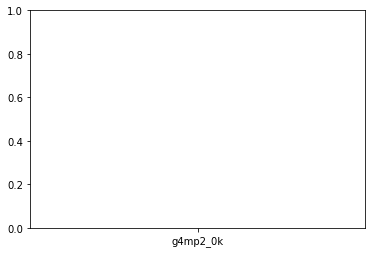

In [47]:
import matplotlib.pyplot as plt
plt.plot(data.T)

In [32]:
normalized_v = data / (np.max(data))
print(normalized_v)

         0         1         2         3         4         5         6    \
0   0.985568  0.974554  0.967136  0.922743  0.888641  0.844765  0.774780   
1   0.996951  0.910588  0.870333  0.785309  0.719948  0.685177  0.623721   
2   0.981740  0.975291  0.978702  0.947858  0.904327  0.855738  0.819252   
3   0.986779  0.943812  0.916487  0.868978  0.807934  0.755135  0.700386   
4   0.976400  0.971306  0.989205  0.964400  0.932321  0.895706  0.843703   
5   0.997398  1.000000  0.998844  0.982026  0.963303  0.935743  0.893533   
6   0.950571  0.941881  0.950574  0.934874  0.908682  0.869152  0.828941   
7   0.991562  0.970828  0.977498  0.939304  0.907334  0.866318  0.800649   
8   0.963152  0.938135  0.949180  0.931660  0.906001  0.906265  0.888776   
9   0.974764  0.949441  0.965401  0.943777  0.920638  0.909354  0.880130   
10  0.962783  0.956147  0.979088  0.974811  0.978524  0.976177  0.981681   
11  1.000000  0.973782  0.962220  0.934380  0.921882  0.872695  0.828743   
12  0.986139

In [33]:
import matplotlib.pyplot as plt

AttributeError: 'Line2D' object has no property 'type'

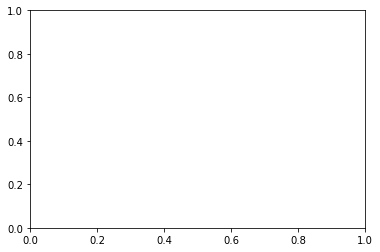

In [34]:
for m in ['model_0.05_val']:
    #model = load_model(m, arch_dir=schnet_dir, weights_dir=schnet_dir)
    data['g4mp2_0k-pred-{}'.format(m)] = run_model(model, data, 'xyz', ['u0'])

KeyError: 'xyz'

### Evaluate FCHL Models
Evaluate the Delta model trained on the largest dataset

In [ ]:
%%time
with gzip.open(os.path.join(fchl_dir, 'fchl_g4mp2-delta.pkl.gz'), 'rb') as fp:
    model = pkl.load(fp)
data['g4mp2_0k-pred-{}'.format('fchl-delta')] = run_qml_model(model, data, 'xyz')

## Compare the Methods
Mkae a histogram so that we can see the distributions of errors

In [ ]:
fig, ax = plt.subplots()

bins = np.linspace(-750, 750, 64)

# Plot B3LYP
error = (data['g4mp2_atom'] - data['u0_atom']) * Hartree / eV * 1000
print('MAE B3LYP: {:.2f} meV'.format(error.abs().mean()))
ax.hist(error, bins=bins, alpha=0.5, color=model_style['B3LYP']['color'],
       label=model_style['B3LYP']['label'])


# Plot the SchNet models
for m in ['g4mp2-delta']:
    error = (data['g4mp2_0k-pred-{}'.format(m)] - data['g4mp2_0k']) * Hartree / eV * 1000
    print('MAE {}: {:.2f} meV'.format(m, error.abs().mean()))
    ax.hist(error, bins=bins, alpha=0.5, color=model_style[m]['color'],
           label=model_style[m]['label'])
    
# Add FCHL
error = (data['g4mp2_atom'] - data['u0_atom'] - data['g4mp2_0k-pred-fchl-delta']) * Hartree / eV * 1000
print('MAE {}: {:.2f} meV'.format('FCHL Delta', error.abs().mean()))
ax.hist(error, bins=bins, alpha=0.5, color=model_style['FCHL Delta']['color'],
       label=model_style['FCHL Delta']['label'])

# Make it pretty
ax.set_xlabel('Error (meV)')
ax.set_ylabel('Frequency')

ax.legend()
fig.tight_layout()
fig.set_size_inches(3.5, 2.5)

In [ ]:
fig, ax = plt.subplots()

# Plot B3LYP
error = (data['g4mp2_atom'] - data['u0_atom']) * Hartree / eV * 1000
print('MAE B3LYP: {:.2f} meV'.format(error.abs().mean()))
ax.plot(data['n_heavy_atoms'], error, **model_style['B3LYP'], linewidth=0)


# Plot the SchNet models
for m in ['g4mp2-delta']:
    error = (data['g4mp2_0k-pred-{}'.format(m)] - data['g4mp2_0k']) * Hartree / eV * 1000
    print('MAE {}: {:.2f} meV'.format(m, error.abs().mean()))
    ax.plot(data['n_heavy_atoms'], error, **model_style[m], linewidth=0)
    
# Add FCHL
error = (data['g4mp2_atom'] - data['u0_atom'] - data['g4mp2_0k-pred-fchl-delta']) * Hartree / eV * 1000
print('MAE {}: {:.2f} meV'.format('FCHL Delta', error.abs().mean()))
ax.plot(data['n_heavy_atoms'], error, **model_style['FCHL Delta'], linewidth=0)

# Make it pretty
ax.set_ylabel('Error (meV)')
ax.set_xlabel('N. Heavy Atoms')

ax.legend()
fig.tight_layout()
fig.set_size_inches(3.5, 2.5)

## No Coordinates or Energies
We just use the atomic coordinates generated from OpenBabel

In [ ]:
%%time
data['xyz_gen'] = data['smiles'].apply(generate_atomic_coordinates)

See how good the predictions are

In [ ]:
%%time
data['rmsd'] = data.apply(lambda x: get_rmsd(x['xyz'], x['xyz_gen']), axis=1)

In [ ]:
data['rmsd'].describe()

In [ ]:
fig, ax = plt.subplots()

ax.scatter(data['n_heavy_atoms'], data['rmsd'])

ax.set_ylabel('RMSD (Ang)')
ax.set_xlabel('Number of Electrons')

fig.set_size_inches(3.5, 2.5)

*Finding*: The RMSD between B3LYP and our generated coordinates is enormous.

## Evaluate the Re-trained SchNet
We are going to use the one trained on conformers with a jitter of 0.1 Å

In [ ]:
model = load_model('g4mp2-transfer', 'relaxed-conformers', '0.1000', arch_dir=schnet_dir,
                  weights_dir=os.path.join('..', 'coordinate-sensitivity'))

In [ ]:
data['g4mp2_0k-pred-schnet-smiles'] = run_model(model, data, 'xyz_gen')

In [ ]:
fig, ax = plt.subplots()


# Plot the SchNet Predictions
error = (data['g4mp2_0k'] - data['g4mp2_0k-pred-schnet-smiles']) * Hartree / eV
ax.scatter(data['n_electrons'], error, **model_style['g4mp2-transfer'])

error = (data['g4mp2_atom'] - data['u0_atom']) * Hartree / eV
ax.scatter(data['n_electrons'], error, **model_style['B3LYP'])

# Add in the zero line
xlim = ax.set_xlim(ax.get_xlim())
ax.plot(xlim, [0,0], 'k--', lw=1)

ax.legend(loc='lower left')

# Make it pretty
ax.set_xlabel('Electron Count')
ax.set_ylabel('Error (eV)')

fig.set_size_inches(3.5, 2)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'large-molecules-generated.png'), dpi=320)

*Finding*: The model accuracy when using conformers severely degrades with atomic size. Our largest molecules have errors of nearly 1 eV, which is likely too large to be useful.

## Save the Data
Save the data for later plotting

In [ ]:
data.to_csv('large-molecule-predictions.csv', index=False)